# III. DETECTING ANOMALIES IN SINGAPORE'S WEATHER PATTERNS

Data visualisation, such as the range of charts in [my earlier notebook](https://github.com/chuachinhon/weather_singapore_cch/blob/master/notebooks/2.0_visualisation_cch.ipynb), provide an easy way to spot outliers, or in this case, abnormal weather patterns. 

But when you have 36 years of weather data, it won't be enough or efficient to rely solely on charts to accurately pick out the outliers.

In this third of a multi-part data science project using [historical weather data](http://www.weather.gov.sg/climate-historical-daily) from Singapore, I'll use Scikit-learn's Isolation Forest model as well as the [PyOD](https://github.com/yzhao062/Pyod) library (Python Outlier Detection) to try to pinpoint anomalies in the dataset.

It will be interesting to see the precise dates where these abnormal weather patterns took place. This is also important pre-work for Part IV of the project - time series forecasting, where removal of the outliers would be key to more accurate predictions. 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go
import plotly.offline as py

import seaborn as sns

from numpy import percentile
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from plotly.subplots import make_subplots 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'
init_notebook_mode(connected=True)

In [3]:
# Original source for the data here: http://www.weather.gov.sg/climate-historical-daily/
# Or, see notebook 1.0
weather = pd.read_csv('../data/weather.csv')

In [4]:
# There are 13,330 rows of weather data in this set. How many are outliers?
weather.shape

(13330, 10)

In [5]:
# Quick look at the summary stats, especially the max values
weather.describe()

Year         Month           Day  Daily Rainfall Total (mm)  \
count  13330.000000  13330.000000  13330.000000               13330.000000   
mean    2000.750863      6.481995     15.727907                   5.851905   
std       10.537707      3.448823      8.799558                  14.455764   
min     1983.000000      1.000000      1.000000                   0.000000   
25%     1992.000000      3.000000      8.000000                   0.000000   
50%     2001.000000      6.000000     16.000000                   0.000000   
75%     2010.000000      9.000000     23.000000                   4.400000   
max     2019.000000     12.000000     31.000000                 216.200000   

       Mean Temperature (°C)  Maximum Temperature (°C)  \
count           13330.000000              13330.000000   
mean               27.657524                 31.510833   
std                 1.173196                  1.571750   
min                22.800000                 23.600000   
25%                26.900000                 30.800000   
50%                27.700000                 31.700000   
75%                28.500000                 32.500000   
max                30.900000                 36.000000   

       Minimum Temperature (°C)  Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
count              13330.000000            13330.000000           13330.000000  
mean                  24.889070                7.402755              34.041722  
std                    1.260053                3.442466               8.052888  
min                   20.200000                0.200000               4.700000  
25%                   24.000000                4.800000              28.800000  
50%                   24.900000                6.800000              33.100000  
75%                   25.700000                9.700000              38.200000  
max                   29.100000               22.200000              90.700000

# 1. FIRST LOOK

Pair plots provide a quick way to understand the relationship between variables in a dataset, and to spot outliers which buck the main trend.

The chart below shows the relationships between wind speed, temperature and rainfall. I've narrowed the number of years to 2000 - 2019 to make the chart less crowded. Check out this [useful tutorial](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) for further exploration of pair plots.

The charts below give us a quick sense of where the weather outliers could be, but pinpointing them won't be easy this way. Let's dive into the other methods available. 

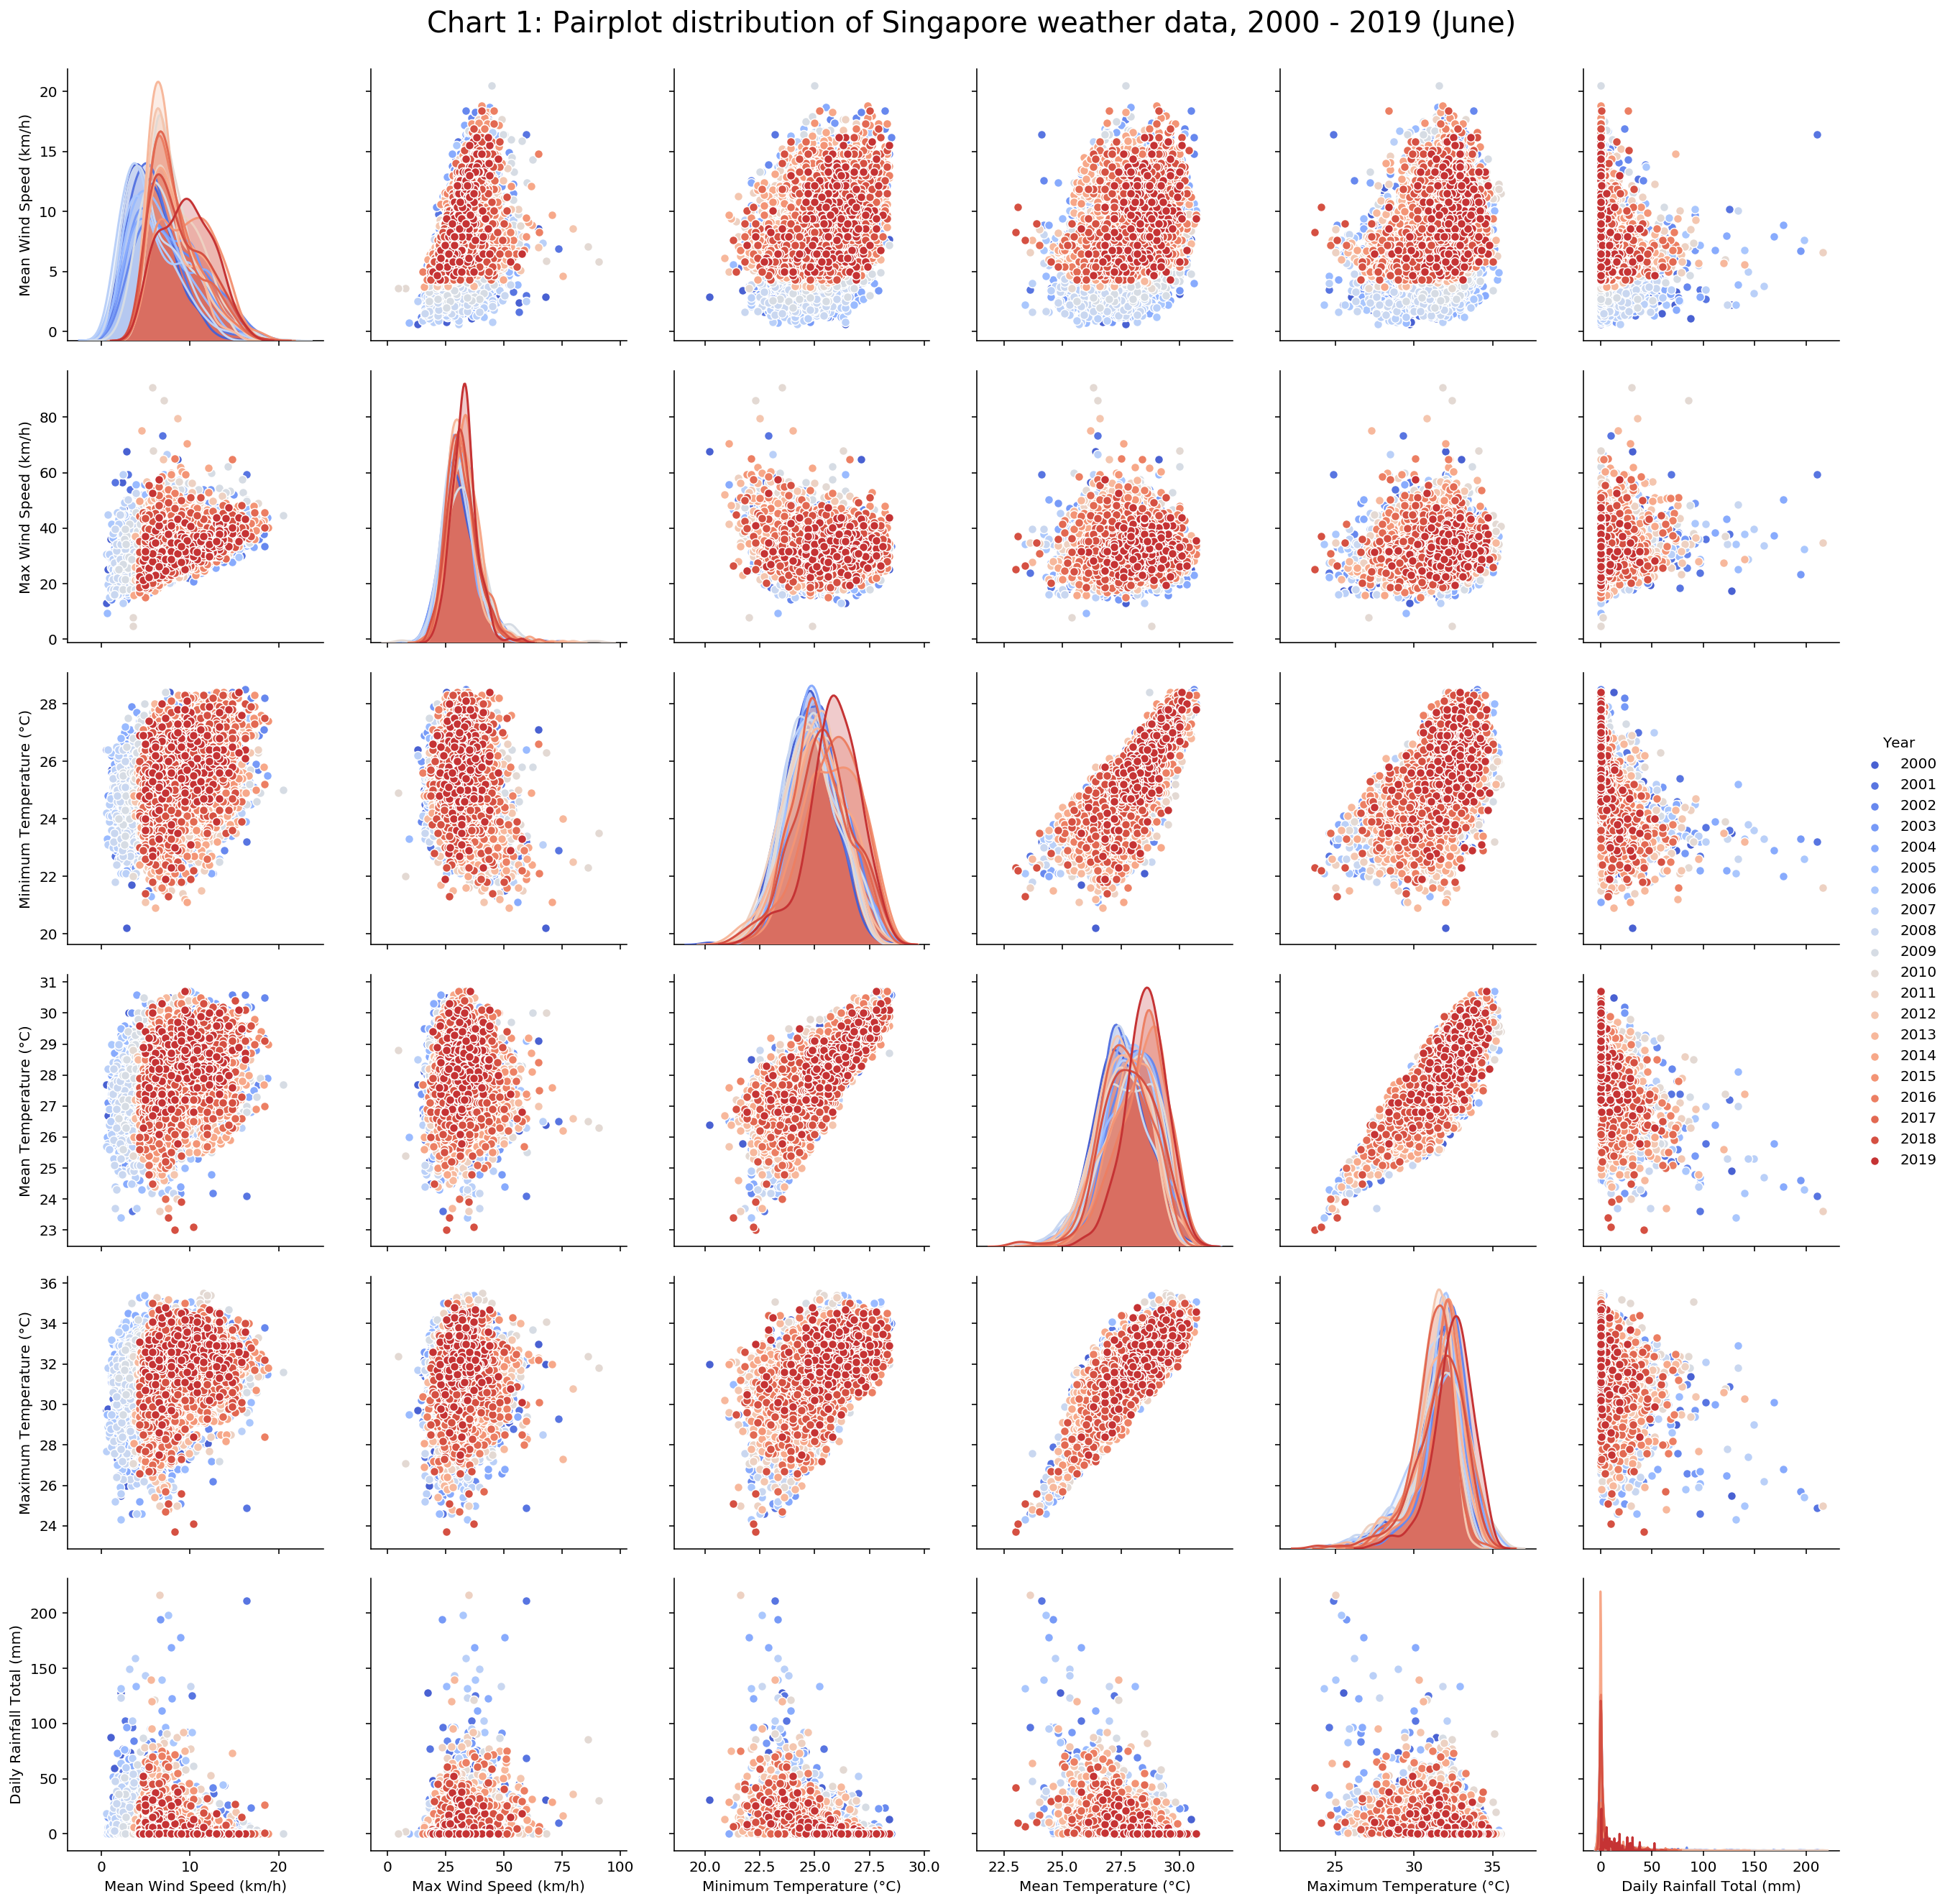

In [6]:
# Tweak the parameter for 'Year' if you wish.

sns.pairplot(
    weather[weather['Year'] >=2000],
    height=3,
    vars=[
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
        "Minimum Temperature (°C)",
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Daily Rainfall Total (mm)",
    ],
    hue="Year",
    palette="coolwarm"
)
plt.suptitle("Chart 1: Pairplot distribution of Singapore weather data, 2000 - 2019 (June)", fontsize=20, y=1.02)
plt.show()

# 2. SINGLE VARIABLE (UNIVARIATE) ANOMALY DETECTION 
Let's start with the simpler single variable analysis using the Isolation Forest model in Scikit-learn before moving on to a multivariate technique using PyOD.

## 2.1 Checking Skew and Kurtosis In Daily Rainfall Data

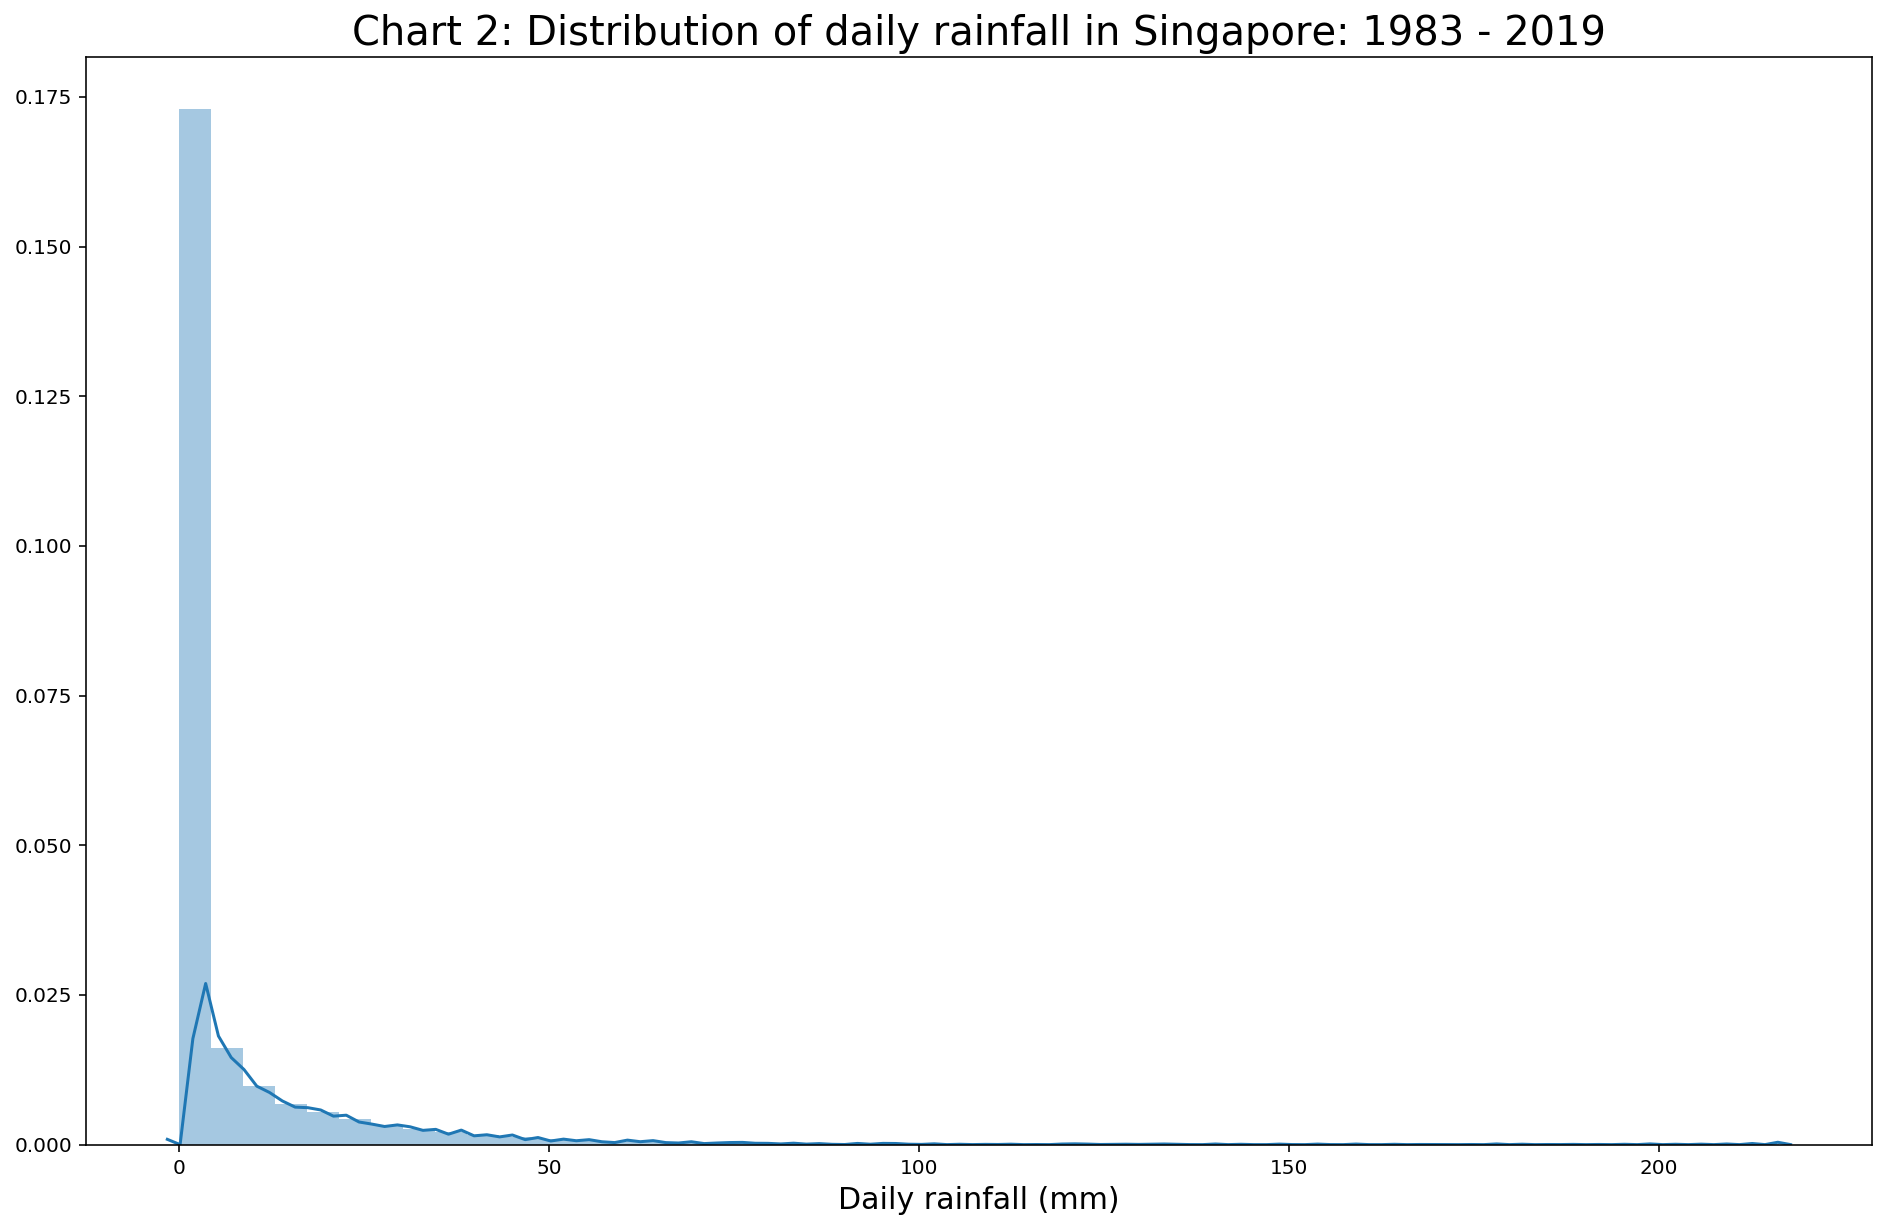

In [7]:
plt.figure(figsize=(16,10))
sns.distplot(weather['Daily Rainfall Total (mm)'])
plt.title('Chart 2: Distribution of daily rainfall in Singapore: 1983 - 2019', fontsize=20)
plt.xlabel("Daily rainfall (mm)", fontsize=15)
plt.show()

In [8]:
print("Skewness: %f" % weather['Daily Rainfall Total (mm)'].skew())
print("Kurtosis: %f" % weather['Daily Rainfall Total (mm)'].kurt())

Skewness: 5.140533
Kurtosis: 40.778205


### SKEWNESS AND KURTOSIS
Skewness is a measure of the degree of distortion in a dataset. A symmetrical dataset with a normal distribution will have a skewness value of 0.

Kurtosis is a measure of the outliers in the distribution. See this [article](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa) here for a reader-friendly explanation.

In the case of the daily rainfall column, we see that the data is highly skewed (skewness score greater than 1) to the right due to days where there are unusual amounts of rain. There's no rain for about half the time as well.

The kurtosis score is also high (a normal distribution has a kurtosis of three), indicating the presence of a considerable number of outliers.  

## 2.2 Using Isolation Forest To Detect Anomalies In Daily Rainfall Data
Isolation Forest is a tree-based model widely used to identify outliers. See these two articles([here](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1) and [here](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e)) for an in-depth explanation. 

In [9]:
# default value for contamination is "auto"
# I opted to go for 0.1 instead

isolation_forest = IsolationForest(
    behaviour="new", n_estimators=500, n_jobs=-1, random_state=42, contamination=0.1
)

isolation_forest.fit(weather["Daily Rainfall Total (mm)"].values.reshape(-1, 1))

IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
        max_features=1.0, max_samples='auto', n_estimators=500, n_jobs=-1,
        random_state=42, verbose=0)

In [10]:
rain = np.linspace(
    weather["Daily Rainfall Total (mm)"].min(),
    weather["Daily Rainfall Total (mm)"].max(),
    len(weather),
).reshape(-1, 1)

anomaly_score_rain = isolation_forest.decision_function(rain)

outlier_rain = isolation_forest.predict(rain)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



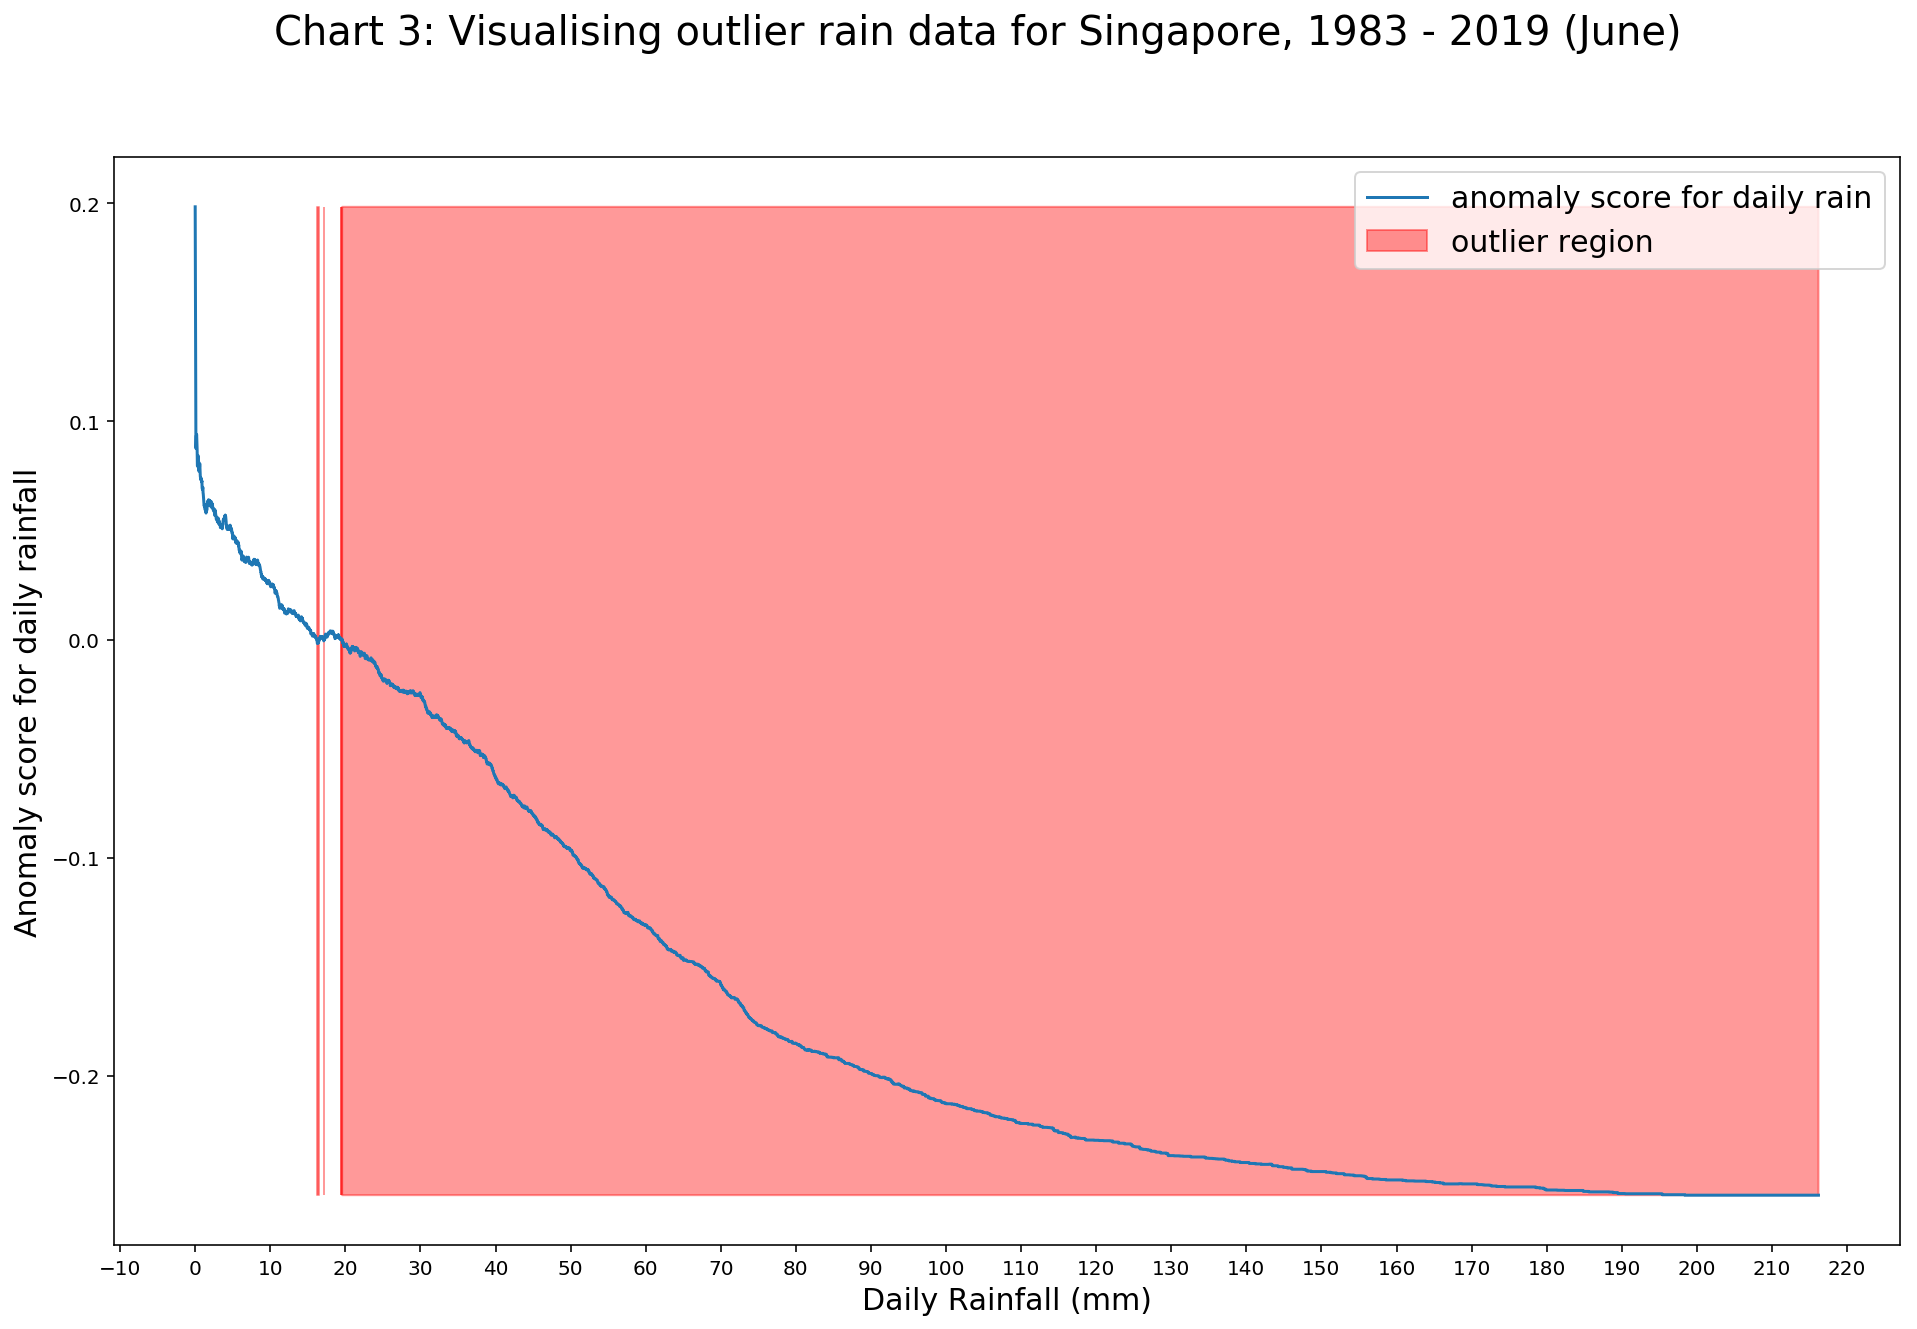

In [11]:
# Plotting the outlier region
plt.figure(figsize=(16, 10))
plt.plot(rain, anomaly_score_rain, label="anomaly score for daily rain")
plt.fill_between(
    rain.T[0],
    np.min(anomaly_score_rain),
    np.max(anomaly_score_rain),
    where=outlier_rain == -1,
    color="r",
    alpha=0.4,
    label="outlier region",
)
plt.legend(fontsize=15)
plt.ylabel("Anomaly score for daily rainfall", fontsize=15)
plt.xlabel("Daily Rainfall (mm)", fontsize=15)
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

plt.suptitle("Chart 3: Visualising outlier rain data for Singapore, 1983 - 2019 (June)", fontsize=20)
plt.show()


In [12]:
# finding where the outlier region begins
idx = np.argwhere(np.diff(np.sign(anomaly_score_rain))).flatten()
rain[idx]

array([[16.18783105],
       [16.49601621],
       [17.09616625],
       [17.14482707],
       [19.39944482],
       [19.43188536],
       [19.44810563],
       [19.46432591],
       [19.49676645],
       [19.54542726],
       [19.56164754]])

In [14]:
# There are about 1,300 entries which the Isolation Forest consider to be outliers
# when contamination, or the proportion of outliers, is set to 0.1/10% 
weather[weather["Daily Rainfall Total (mm)"] > 19.4].count()[0]

1300

### NOTE:

This seems an awfully large number of outliers to try to remove. We can reduce this further by lowering the contamination parameter(which sets the proportion of outliers in the data set) to, say, 0.05.

But clearly we shouldn't consider rainfall outliers in isolation, and should instead consider them in relation to other variables like temperature. Let's repeat the same process for another single variable before deciding what to do. 

## 2.3 Checking Skew and Kurtosis In Daily Maximum Temperature Data

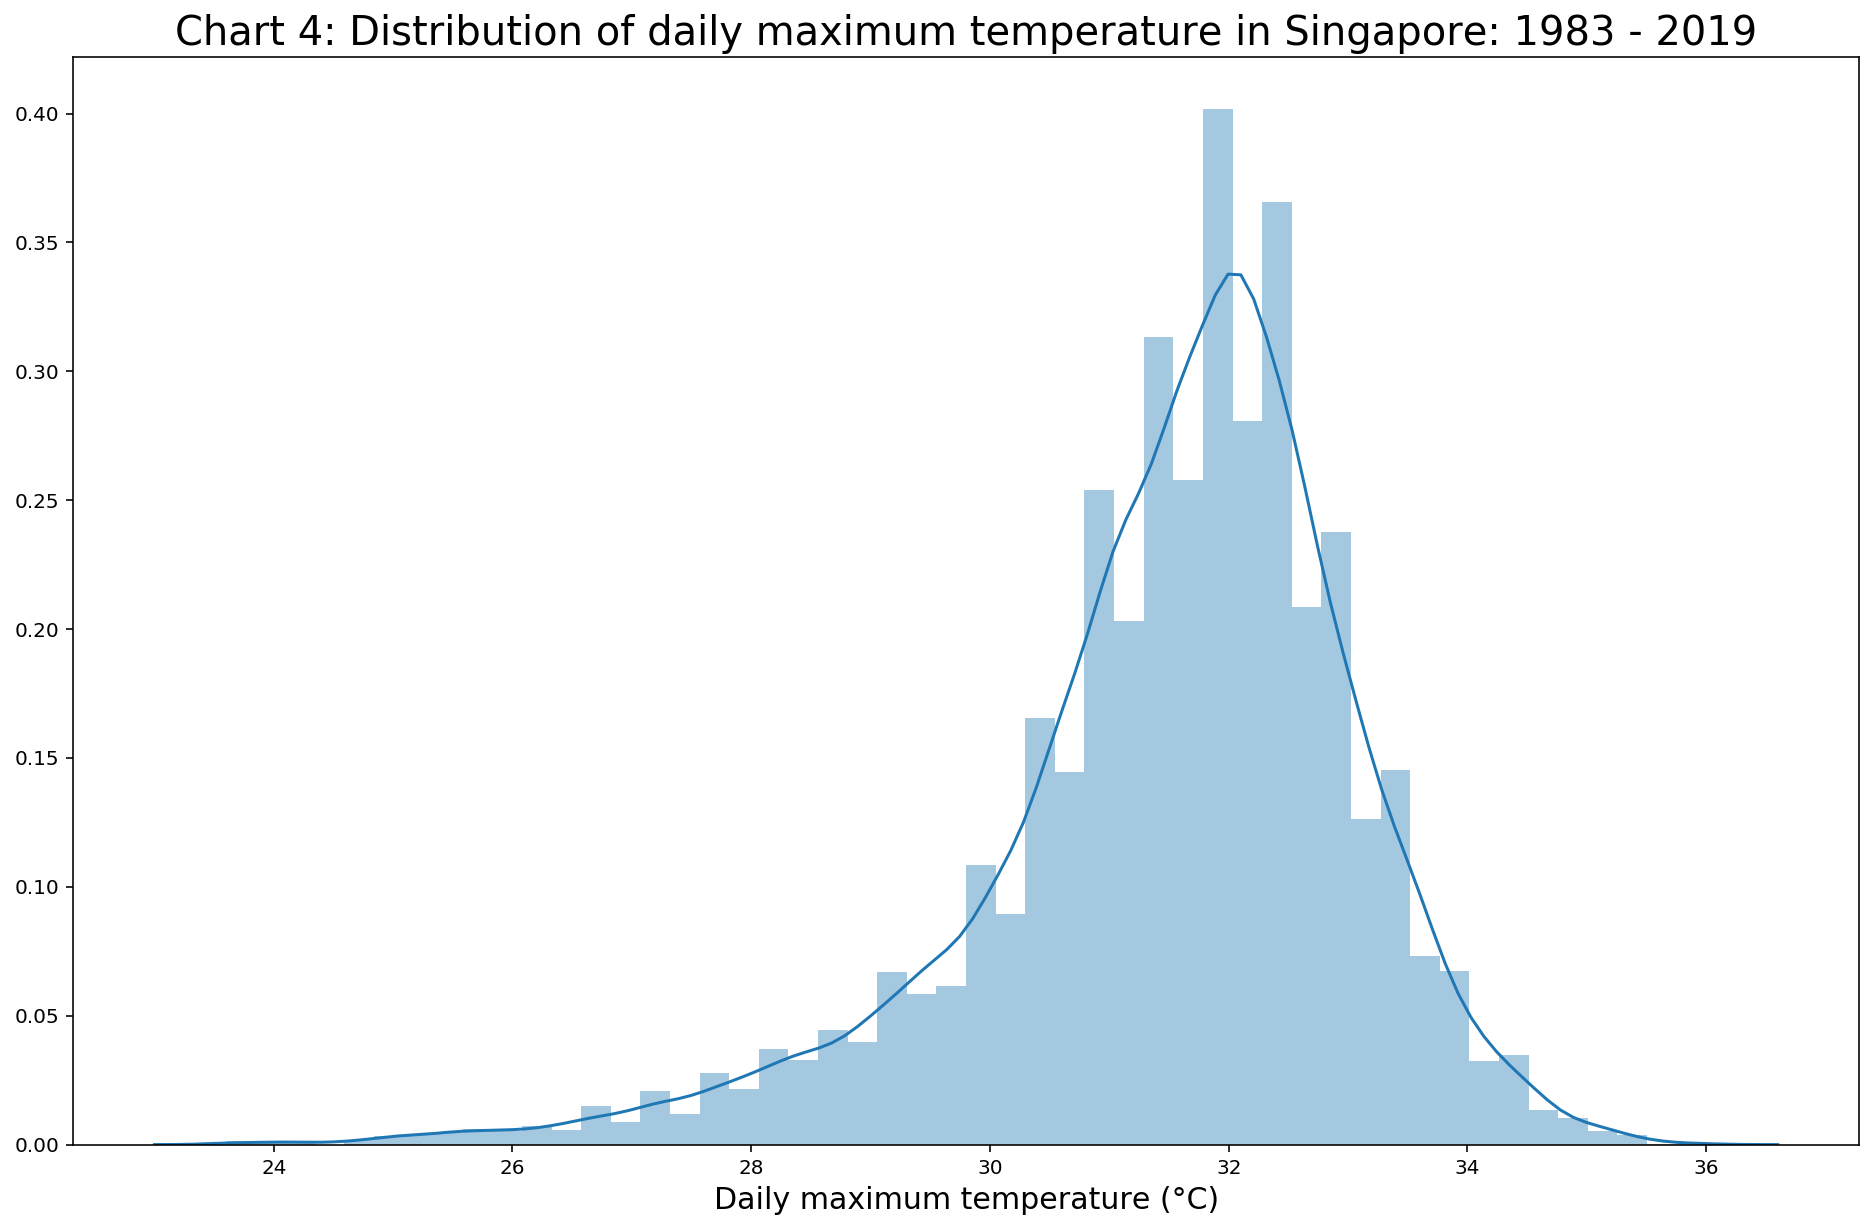

In [15]:
plt.figure(figsize=(16,10))
sns.distplot(weather["Maximum Temperature (°C)"])
plt.title('Chart 4: Distribution of daily maximum temperature in Singapore: 1983 - 2019', fontsize=20)
plt.xlabel("Daily maximum temperature (°C)", fontsize=15)
plt.show()

In [16]:
print("Skewness: %f" % weather["Maximum Temperature (°C)"].skew())
print("Kurtosis: %f" % weather["Maximum Temperature (°C)"].kurt())

Skewness: -1.004003
Kurtosis: 1.883689


The daily maximum temperature column is also highly skewed, negatively this time. 

## 2.4 Using Isolation Forest To Detect Anomalies In Daily Maximum Temperature Data

In [17]:
# default value for contamination is "auto"
# I opted to go for 0.1 instead

isolation_forest = IsolationForest(
    behaviour="new", n_estimators=500, n_jobs=-1, random_state=42, contamination=0.1
)

isolation_forest.fit(weather["Maximum Temperature (°C)"].values.reshape(-1, 1))

IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
        max_features=1.0, max_samples='auto', n_estimators=500, n_jobs=-1,
        random_state=42, verbose=0)

In [18]:
max_temp = np.linspace(
    weather["Maximum Temperature (°C)"].min(),
    weather["Maximum Temperature (°C)"].max(),
    len(weather),
).reshape(-1, 1)

anomaly_score_maxtemp = isolation_forest.decision_function(max_temp)

outlier_maxtemp = isolation_forest.predict(max_temp)

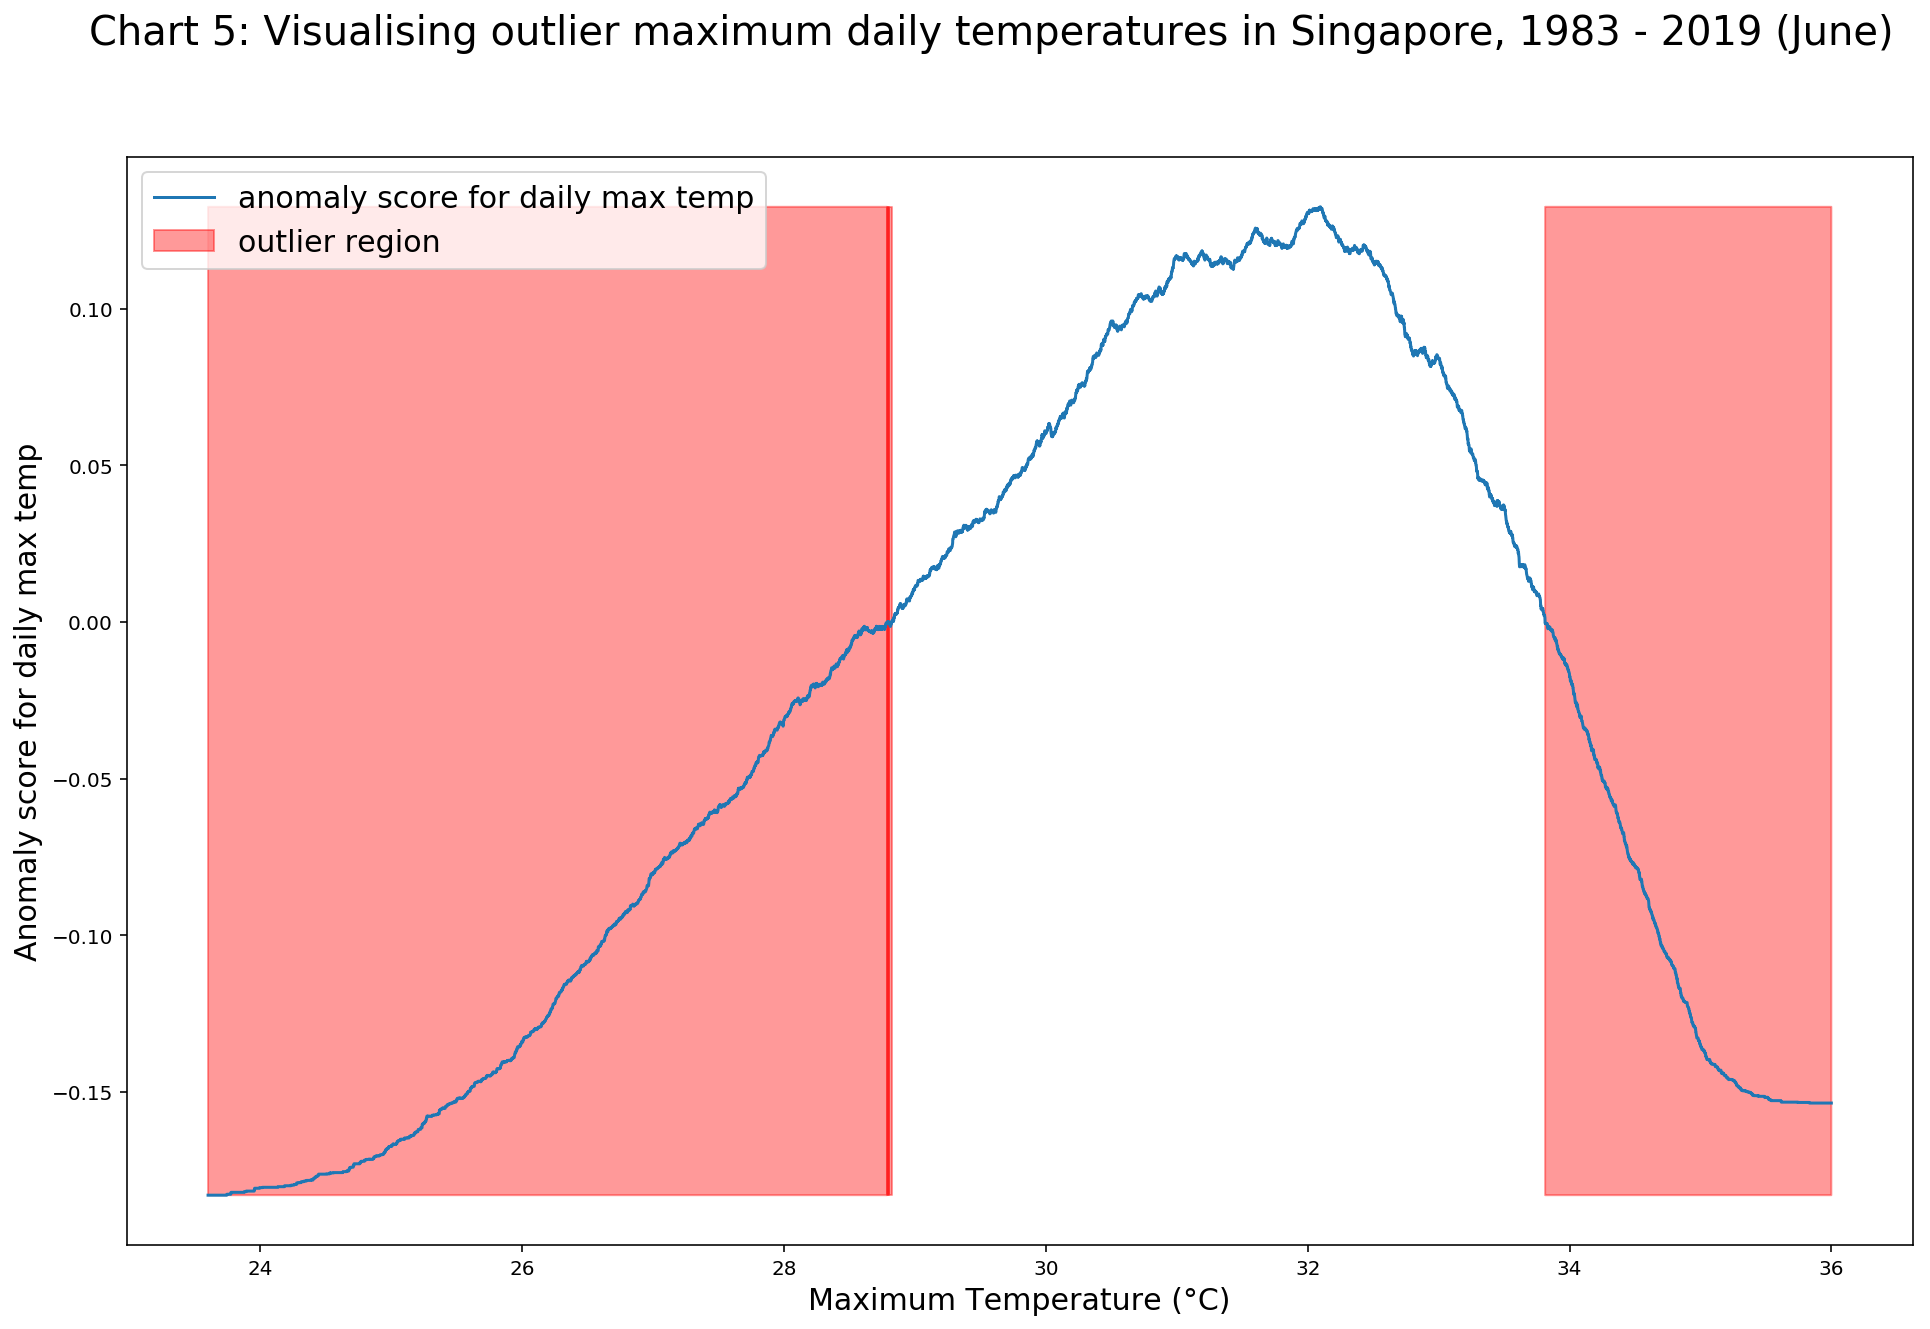

In [19]:
plt.figure(figsize=(16,10))
plt.plot(max_temp, anomaly_score_maxtemp, label='anomaly score for daily max temp')
plt.fill_between(max_temp.T[0], np.min(anomaly_score_maxtemp), np.max(anomaly_score_maxtemp), 
                 where=outlier_maxtemp==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend(fontsize=15)
plt.ylabel('Anomaly score for daily max temp', fontsize=15)
plt.xlabel('Maximum Temperature (°C)', fontsize=15)

plt.suptitle("Chart 5: Visualising outlier maximum daily temperatures in Singapore, 1983 - 2019 (June)", fontsize=20)
plt.show()

In [20]:
# Checking on number of outliers in the "red zone" --> 3782
weather[(weather['Maximum Temperature (°C)'] < 28.5) | (weather['Maximum Temperature (°C)'] >= 33.8)].count()[0]

1223

The univariate analysis of the daily rainfall and daily maximum temperature both turn up more than a thousand outlier entries each. This is problematic as removing them would mean losing about 9% - 10% of the data.

Considering them in isolation might not make sense either, since a "freak storm" is likely to register outlier values for rainfall, wind speed and temperature. Let's move on to the PYOD library instead and see how the results vary.

# 3. MULTIVARIATE ANOMALY DETECTION USING PYOD
I opted for two variables - maximum daily temperature and daily rainfall - since these are the variables that are most closely associated with abnormal weather in Singapore. You can use more than two variables, but this will complicate the visualisation of the results.

The code below were adapted the excellent example notebooks in the [PyOD repo](https://github.com/yzhao062/Pyod) as well as tutorials by [Lakshay Arora](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/) and [Susan Li](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Anomaly_Detection_for_Dummies.ipynb).

The PyOD library works great out of the box, but the challenge here is domain knowledge. Like in the case of the Isolation Forest model, one key parameter you'll have to set for PyOD is the contamination/outliers_fraction - the percentage of outliers you expect to find in the dataset. The default value is 0.1, or 10%. 

That may be an over or under-estimation for our dataset. Without better meteorological knowledge, it is hard to say what's a "correct" outliers fraction to set. 

Since I have no expertise in this area, I used a trial-and-error process to see if the outliers identified by the models matched certain key dates where extreme weather, such as flash floods, had been [reported](http://eresources.nlb.gov.sg/infopedia/articles/SIP_780_2004-12-30.html). 

Examples include the flash floods in [2010, 2011](https://www.pub.gov.sg/Documents/fullReport.pdf) and [2018](https://www.todayonline.com/singapore/flash-floods-hit-parts-eastern-spore-after-heavy-rain).

Eventually, I settled on an outliers_fraction of 0.04. Anything lower would have missed key dates where abnormal weather patterns had been reported. The 4 models I'm using in the PyOD library also identified slightly different outlier points. What I'll do is to aggregate all the unique outlier points for a more comprehensive set.    

In [21]:
# Data pre-processing
cols = ['Daily Rainfall Total (mm)', 'Maximum Temperature (°C)']
minmax = MinMaxScaler(feature_range=(0, 1))
weather[cols] = minmax.fit_transform(weather[cols])
weather[cols].head()

Daily Rainfall Total (mm)  Maximum Temperature (°C)
0                   0.000000                  0.588710
1                   0.085106                  0.677419
2                   0.000000                  0.693548
3                   0.000000                  0.693548
4                   0.000000                  0.612903

In [22]:
X1 = weather['Maximum Temperature (°C)'].values.reshape(-1,1)
X2 = weather['Daily Rainfall Total (mm)'].values.reshape(-1,1)

X = np.concatenate((X1,X2), axis=1)

In [23]:
outliers_fraction = 0.04

# Picking 4 outlier detection models here. You can include others
classifiers = {
    "Cluster-based Local Outlier Factor (CBLOF)": CBLOF(
        contamination=outliers_fraction, check_estimator=False, random_state=42
    ),
    "Histogram-base Outlier Detection (HBOS)": HBOS(contamination=outliers_fraction),
    "Isolation Forest": IForest(
        contamination=outliers_fraction, random_state=42, behaviour="new"
    ),
    "K Nearest Neighbors (KNN)": KNN(contamination=outliers_fraction),
}

OUTLIERS: 534 | INLIERS: 12796 | MODEL: Cluster-based Local Outlier Factor (CBLOF)


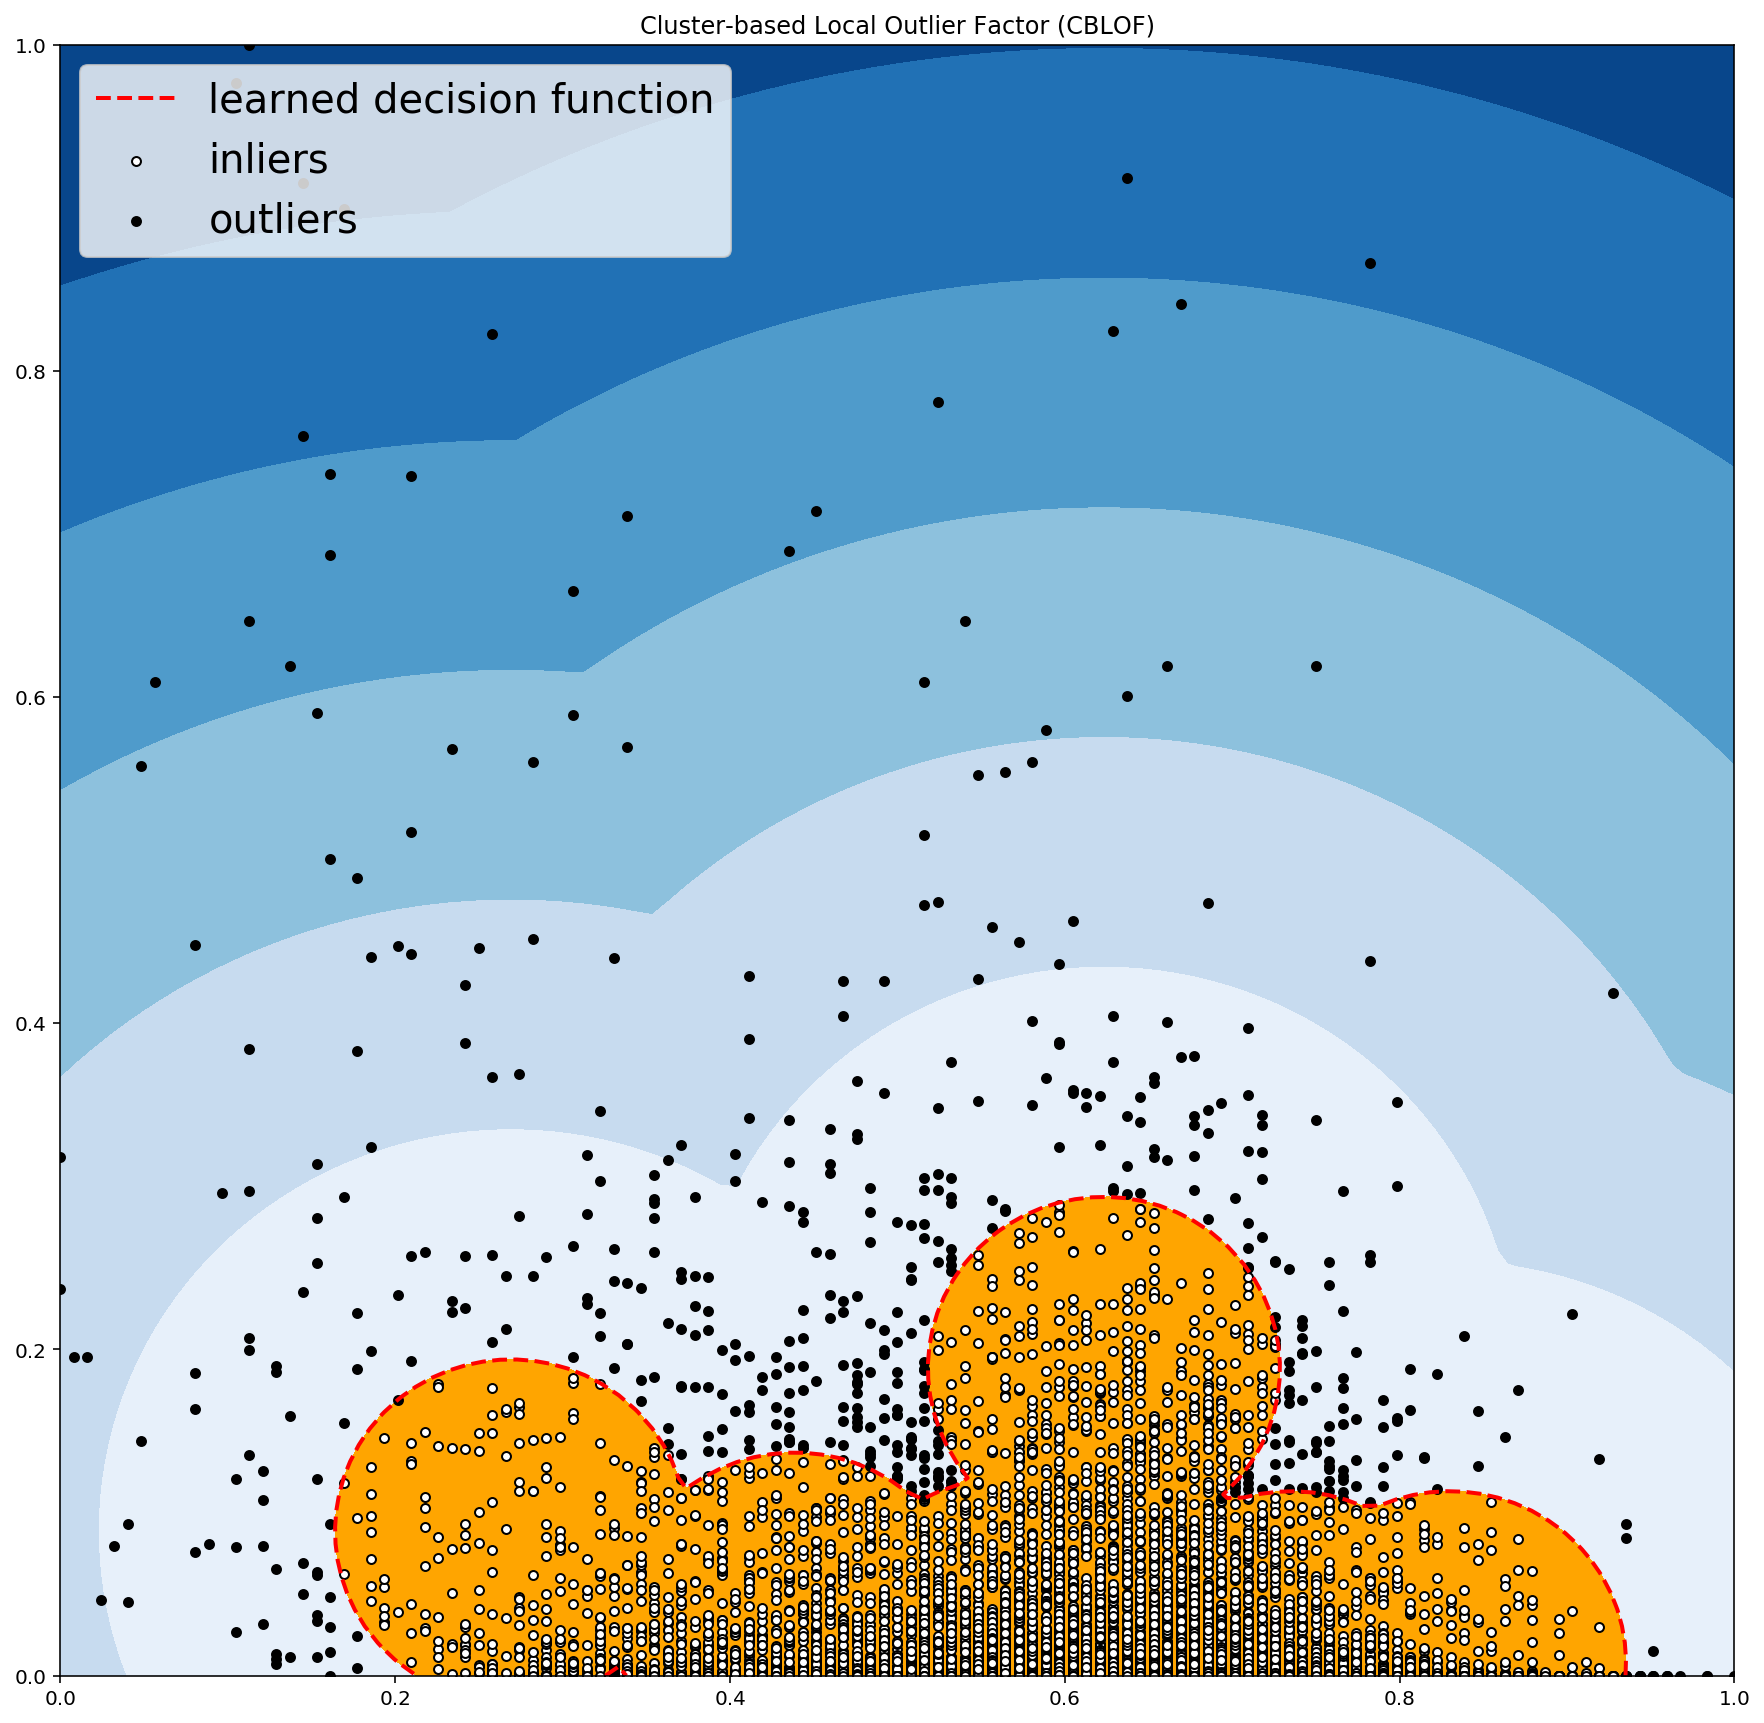

OUTLIERS: 526 | INLIERS: 12804 | MODEL: Histogram-base Outlier Detection (HBOS)


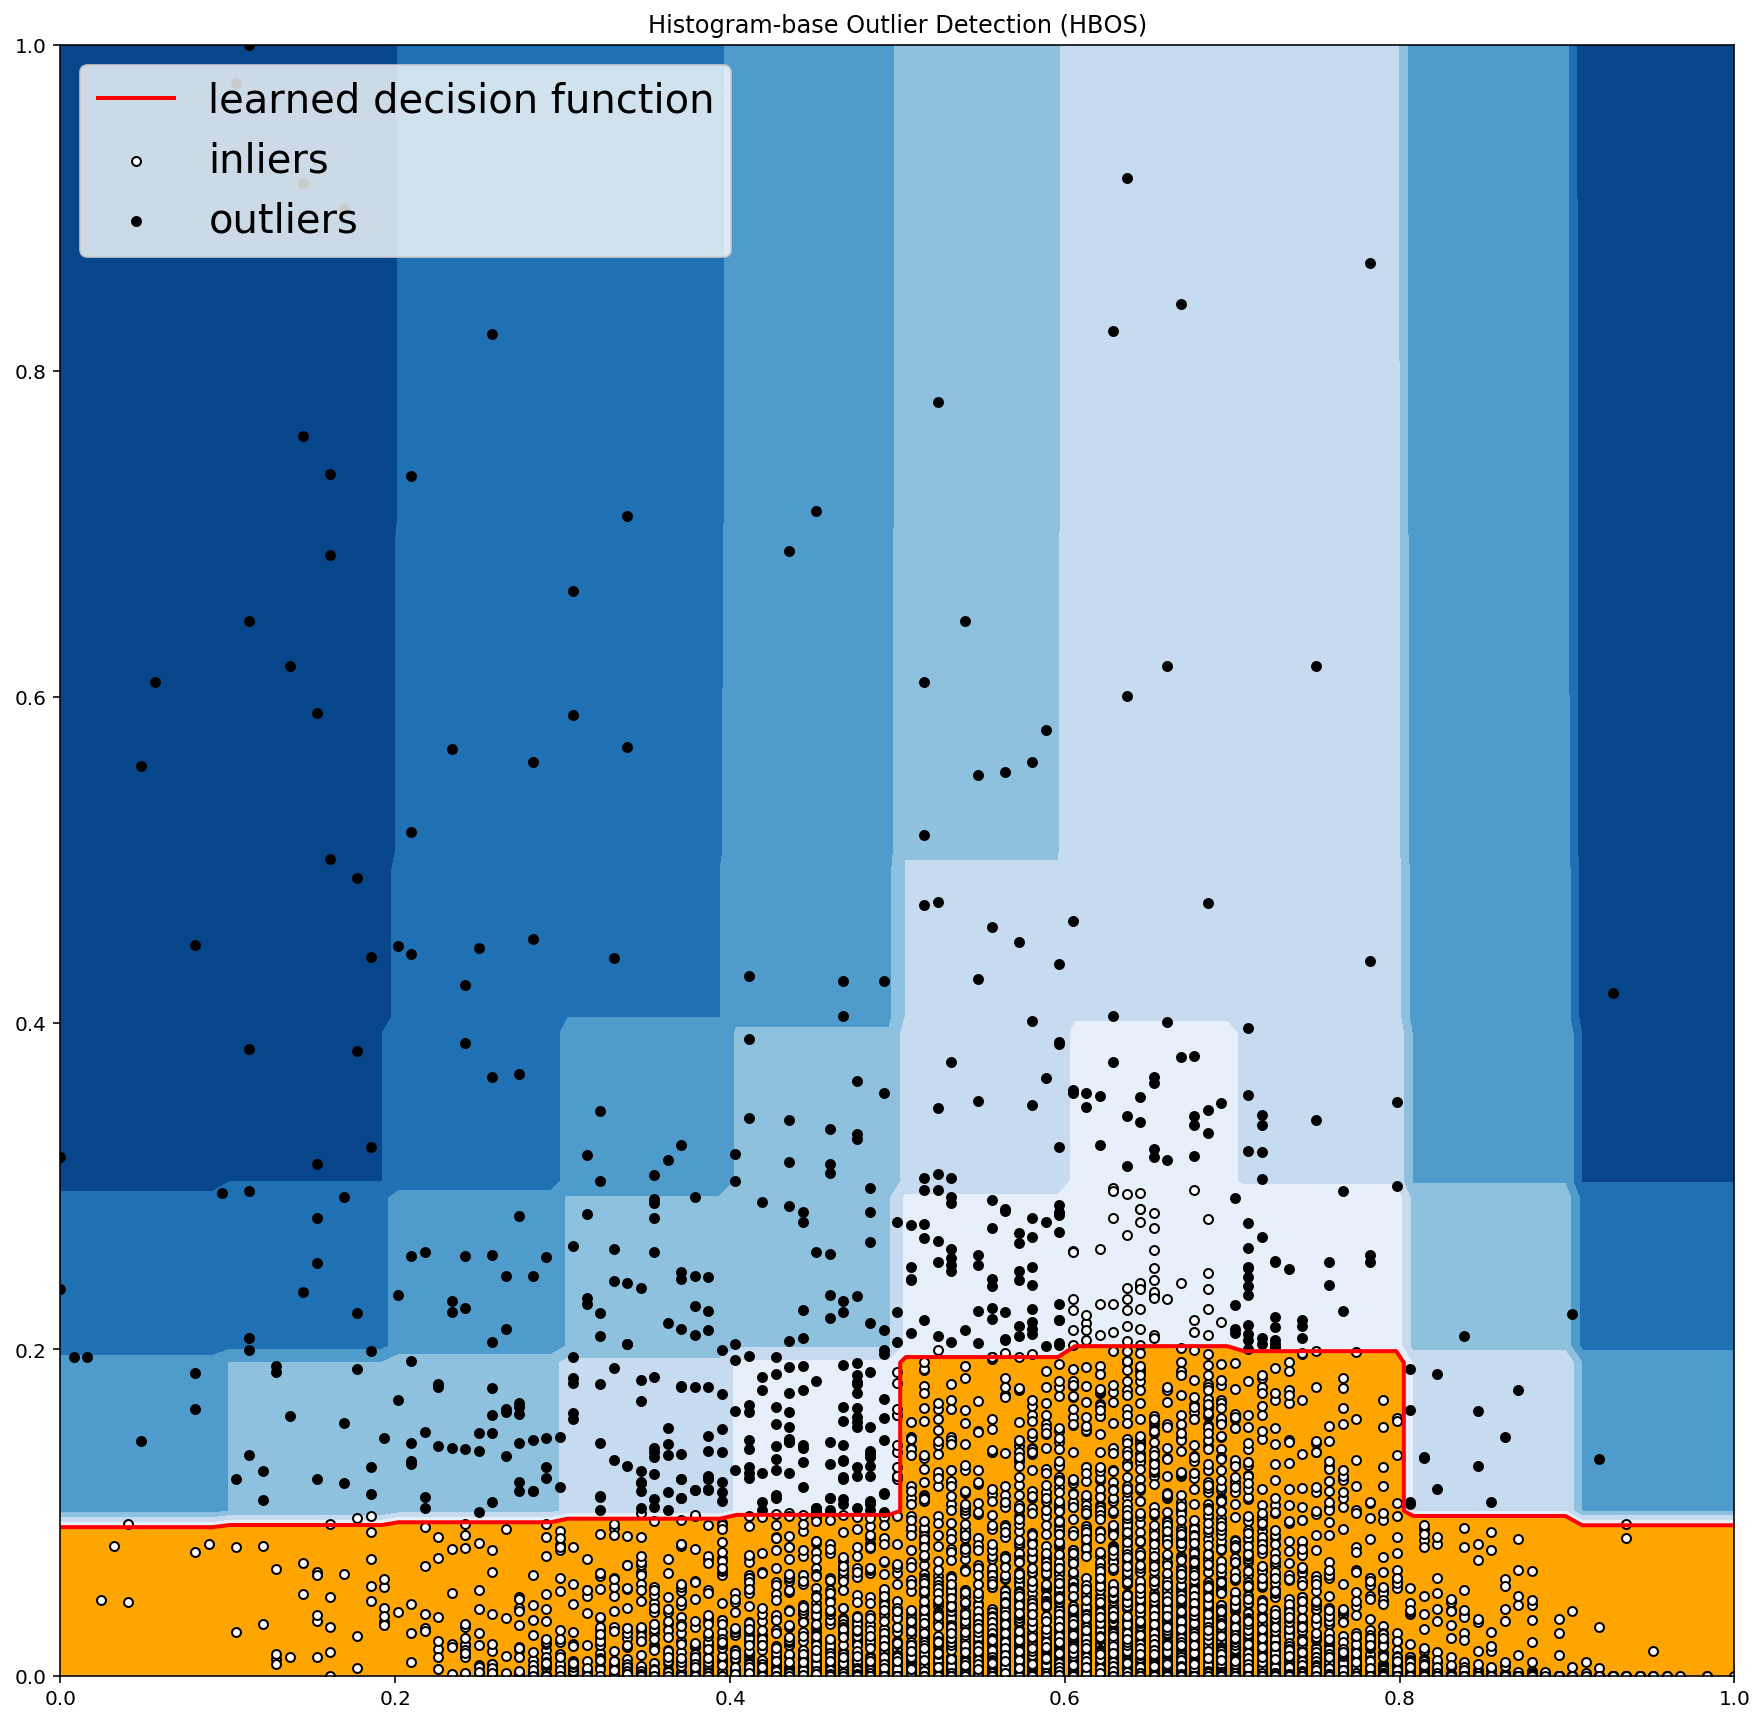

OUTLIERS: 534 | INLIERS: 12796 | MODEL: Isolation Forest


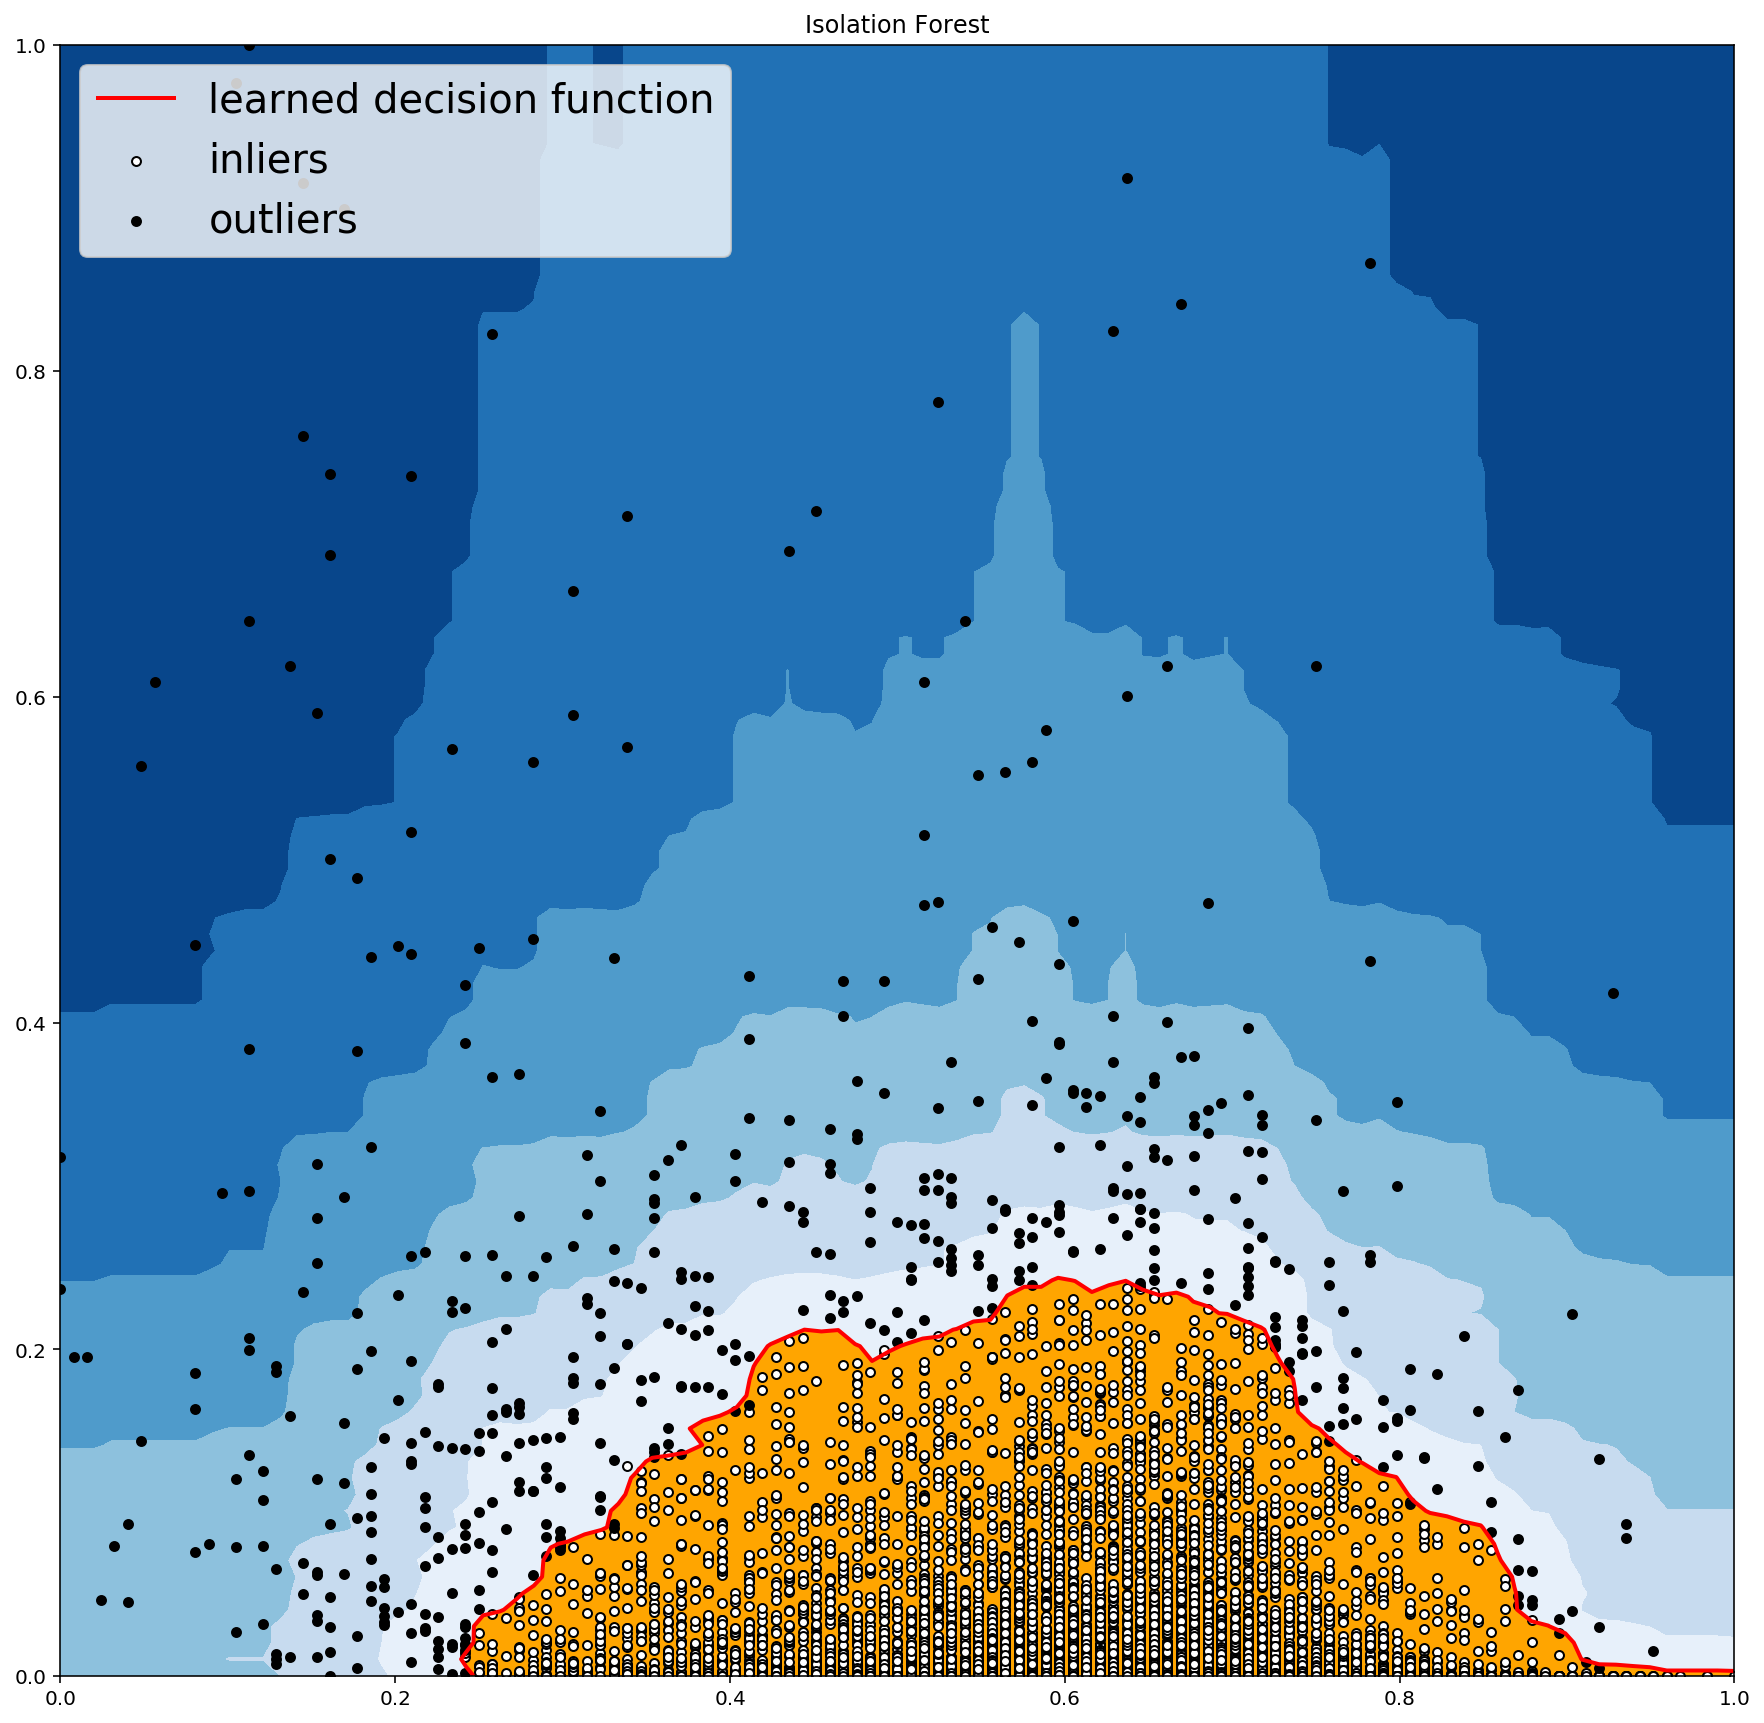

OUTLIERS: 455 | INLIERS: 12875 | MODEL: K Nearest Neighbors (KNN)


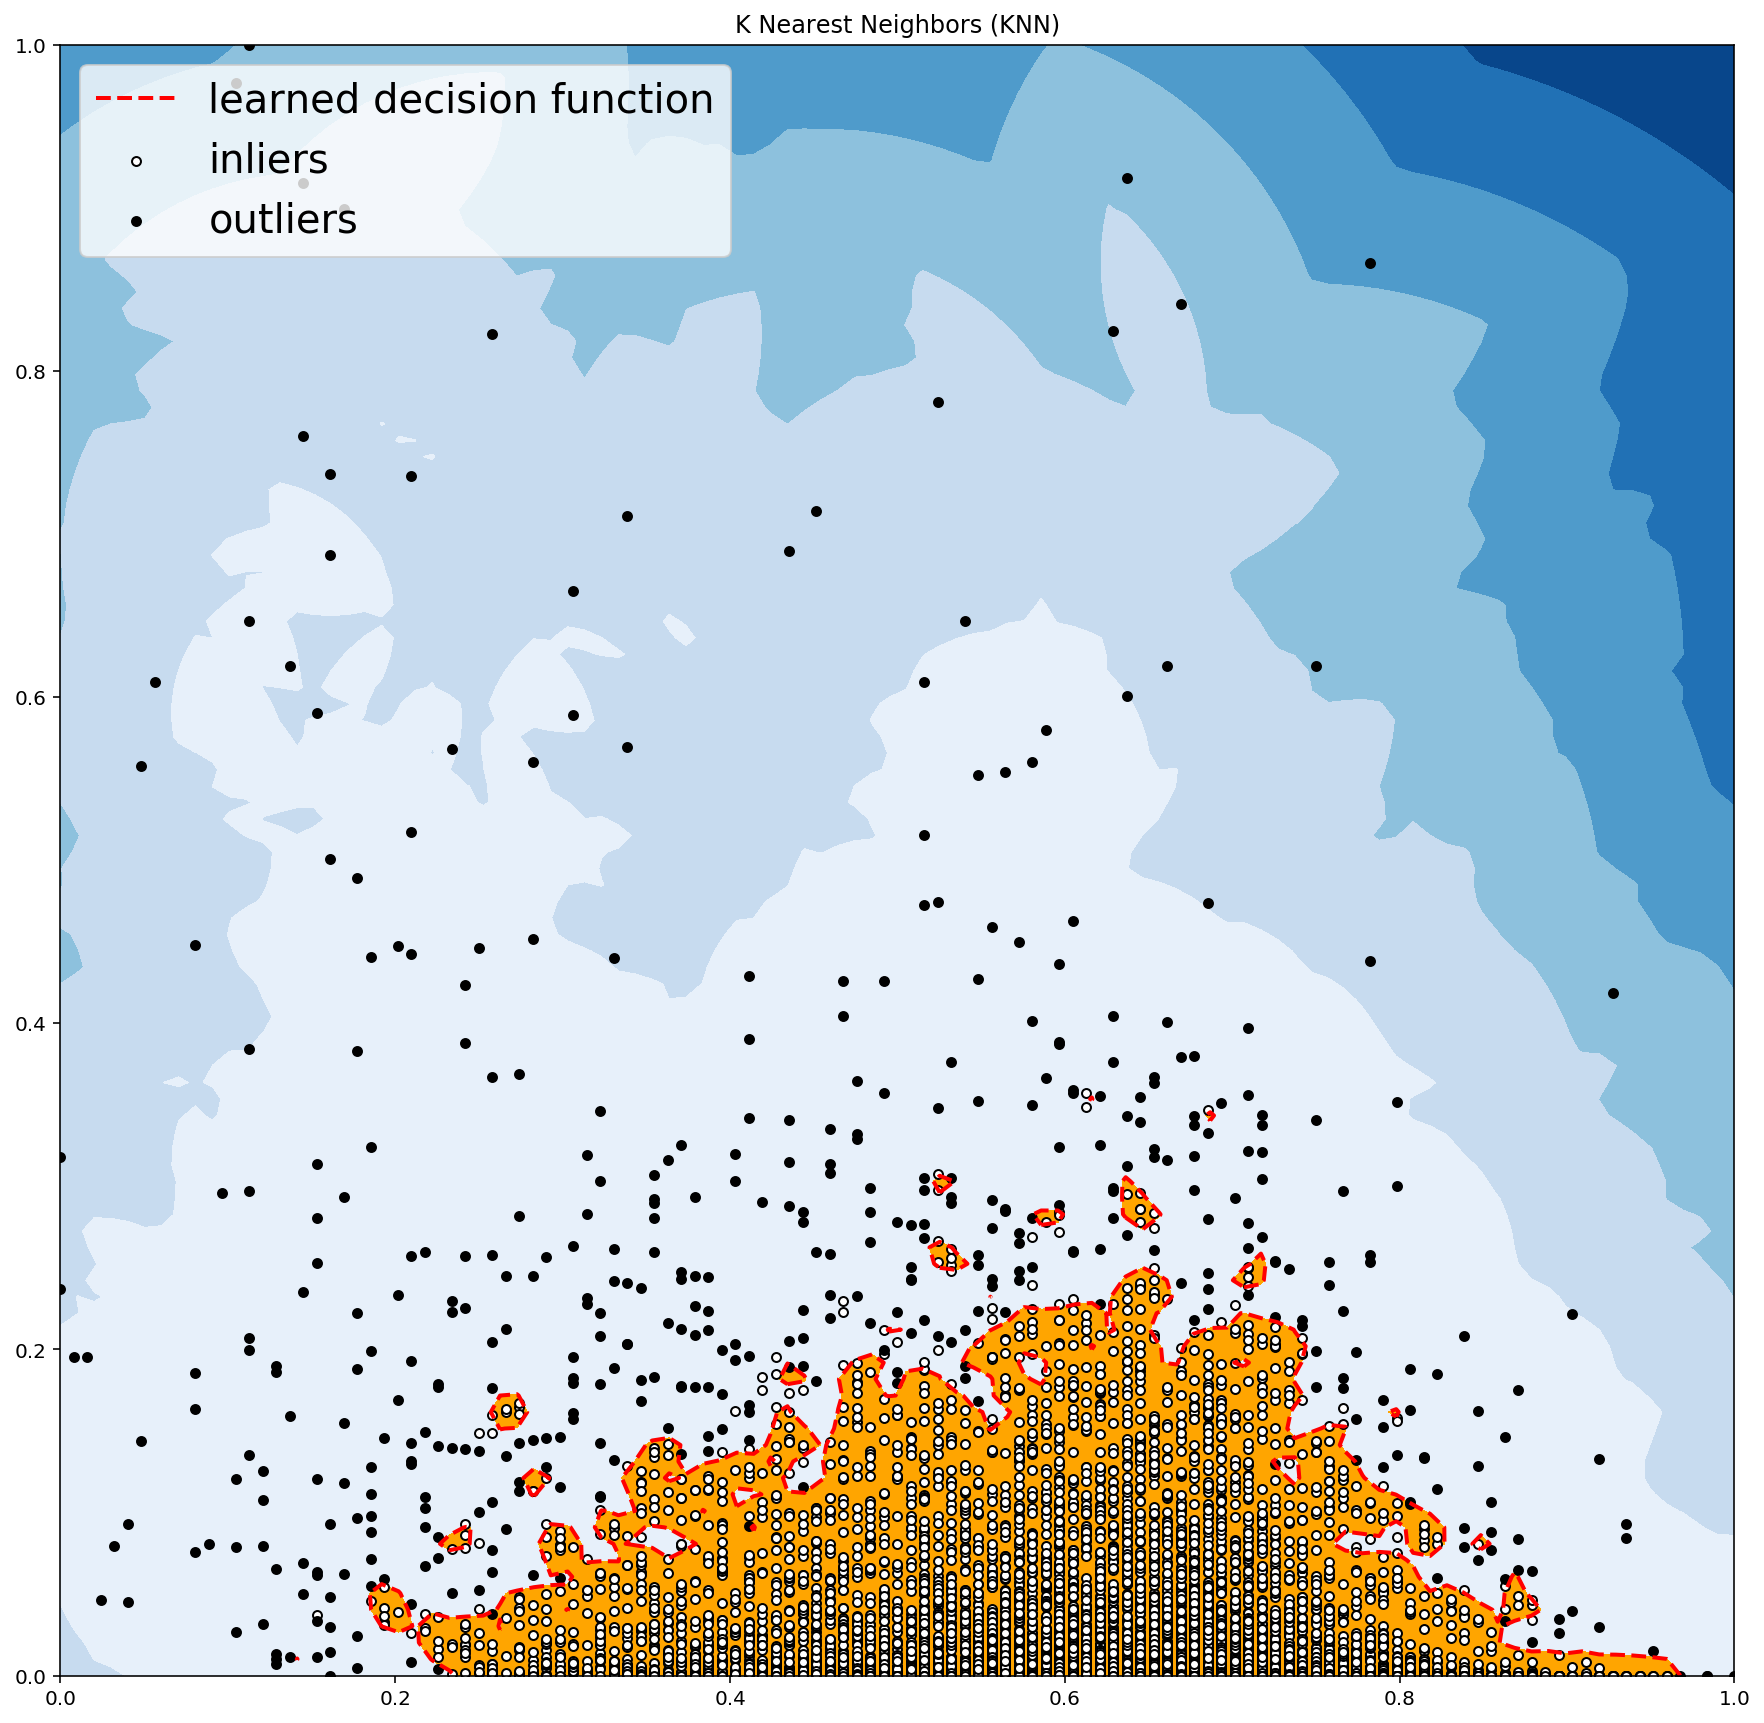

In [24]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
outliers = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(15, 15))
    
    # copy of dataframe
    df = weather.copy()
    df['outlier'] = y_pred.tolist()
    
    # creating a combined dataframe of outliers from the 4 models
    outliers.append(df.loc[df['outlier'] == 1])
    outliers_df = pd.concat(outliers) 
    
    # IN1 - inlier feature 1,  IN2 - inlier feature 2
    IN1 =  np.array(df['Maximum Temperature (°C)'][df['outlier'] == 0]).reshape(-1,1)
    IN2 =  np.array(df['Daily Rainfall Total (mm)'][df['outlier'] == 0]).reshape(-1,1)
     
    
    # OUT1 - outlier feature 1, OUT2 - outlier feature 2
    OUT1 =  df['Maximum Temperature (°C)'][df['outlier'] == 1].values.reshape(-1,1)
    OUT2 =  df['Daily Rainfall Total (mm)'][df['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS:',n_outliers, '|', 'INLIERS:',n_inliers, '|', 'MODEL:',clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
           
    b = plt.scatter(IN1,IN2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OUT1,OUT2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=mpl.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

## 3.1 INSPECTING THE OUTLIERS
The charts above are great for giving a quick sense of how the models have classified the outliers/inliers. But what's going to be really useful is the combined dataframe containing the outlier weather data.

In [25]:
# filtering out the duplicates in the concatenated dataframe
outlier_dates = outliers_df['Date'].unique()
outlier_dates = np.sort(outlier_dates)[::-1]
#outlier_dates

In [26]:
# re-calling the weather dataset again with a new name
# so that original values are available for visualisation when the outliers are extracted in following cell
raw = pd.read_csv('../data/weather.csv')

In [27]:
abnormal_weather = raw[raw.Date.isin(outlier_dates)]

In [28]:
abnormal_weather.head()

Date  Year  Month  Day  Daily Rainfall Total (mm)  \
51   2019-05-10  2019      5   10                        5.6   
65   2019-04-26  2019      4   26                       52.4   
94   2019-03-28  2019      3   28                       29.0   
111  2019-03-11  2019      3   11                       25.8   
163  2019-01-18  2019      1   18                       38.2   

     Mean Temperature (°C)  Maximum Temperature (°C)  \
51                    29.5                      34.7   
65                    26.3                      29.9   
94                    27.9                      33.7   
111                   27.4                      33.0   
163                   25.8                      28.4   

     Minimum Temperature (°C)  Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
51                       24.3                     6.5                   43.9  
65                       24.0                     4.7                   28.4  
94                       22.9                     8.6                   34.9  
111                      22.3                     7.9                   41.0  
163                      23.5                     8.6                   31.7

In [29]:
abnormal_weather.describe()

Year       Month         Day  Daily Rainfall Total (mm)  \
count   816.000000  816.000000  816.000000                 816.000000   
mean   2000.099265    6.714461   14.924020                  43.672426   
std      10.469761    3.979775    8.883105                  32.803023   
min    1983.000000    1.000000    1.000000                   0.000000   
25%    1991.000000    3.000000    7.000000                  24.500000   
50%    2000.000000    7.000000   14.000000                  36.450000   
75%    2009.000000   11.000000   23.000000                  55.950000   
max    2019.000000   12.000000   31.000000                 216.200000   

       Mean Temperature (°C)  Maximum Temperature (°C)  \
count             816.000000                816.000000   
mean               26.242157                 29.543873   
std                 1.498707                  2.775195   
min                22.800000                 23.600000   
25%                25.200000                 27.300000   
50%                26.100000                 29.500000   
75%                27.100000                 31.700000   
max                30.600000                 36.000000   

       Minimum Temperature (°C)  Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
count                816.000000              816.000000             816.000000  
mean                  23.618627                5.843876              36.634487  
std                    1.094850                2.822682               9.960715  
min                   21.000000                0.800000              16.200000  
25%                   22.975000                3.800000              29.900000  
50%                   23.500000                5.600000              35.600000  
75%                   24.100000                7.225000              41.800000  
max                   28.400000               18.400000              86.000000

In [30]:
abnormal_weather.shape

(816, 10)

### In all, the PyOD models picked out 816 unique outliers out of a total of 13,330 data points, or about 6% of the dataset. On inspection, the models managed to pick out the heaviest single day of rainfall in the last 36 years - Jan 30 2011 when 216.2mm of rain fell. PyOD also successfully picked out the highest daily temperature measured - 36°C, on March 26 1998.

# 4. VISUALISING ABNORMAL WEATHER PATTERNS IN SINGAPORE
Let's build on some of the visualising techniques in [notebook2.0](https://github.com/chuachinhon/weather_singapore_cch/blob/master/notebooks/2.0_visualisation_cch.ipynb) and apply them here.

## 4.1 BREAKING DOWN THE DISTRIBUTION OF ABNORMAL WEATHER PATTERN - BY YEAR-MONTH

Let's take a closer at the patterns by year, month and year-month combination.

In [31]:
# At a glance, we can see which particular month-year had the highest number of outlier weather patterns over the last 36 years
abnormal_weather.groupby(['Year']).Month.value_counts().sort_values(ascending=False).head(20)

Year  Month
2010  3        10
1987  1        10
1991  12       10
1983  4         9
1992  12        9
1983  12        8
2006  12        8
1998  12        8
2008  3         7
1986  1         7
2007  1         7
2018  1         7
1989  11        6
2011  1         6
1998  3         6
2013  2         6
1986  12        6
2005  5         6
2006  1         6
1995  2         6
Name: Month, dtype: int64

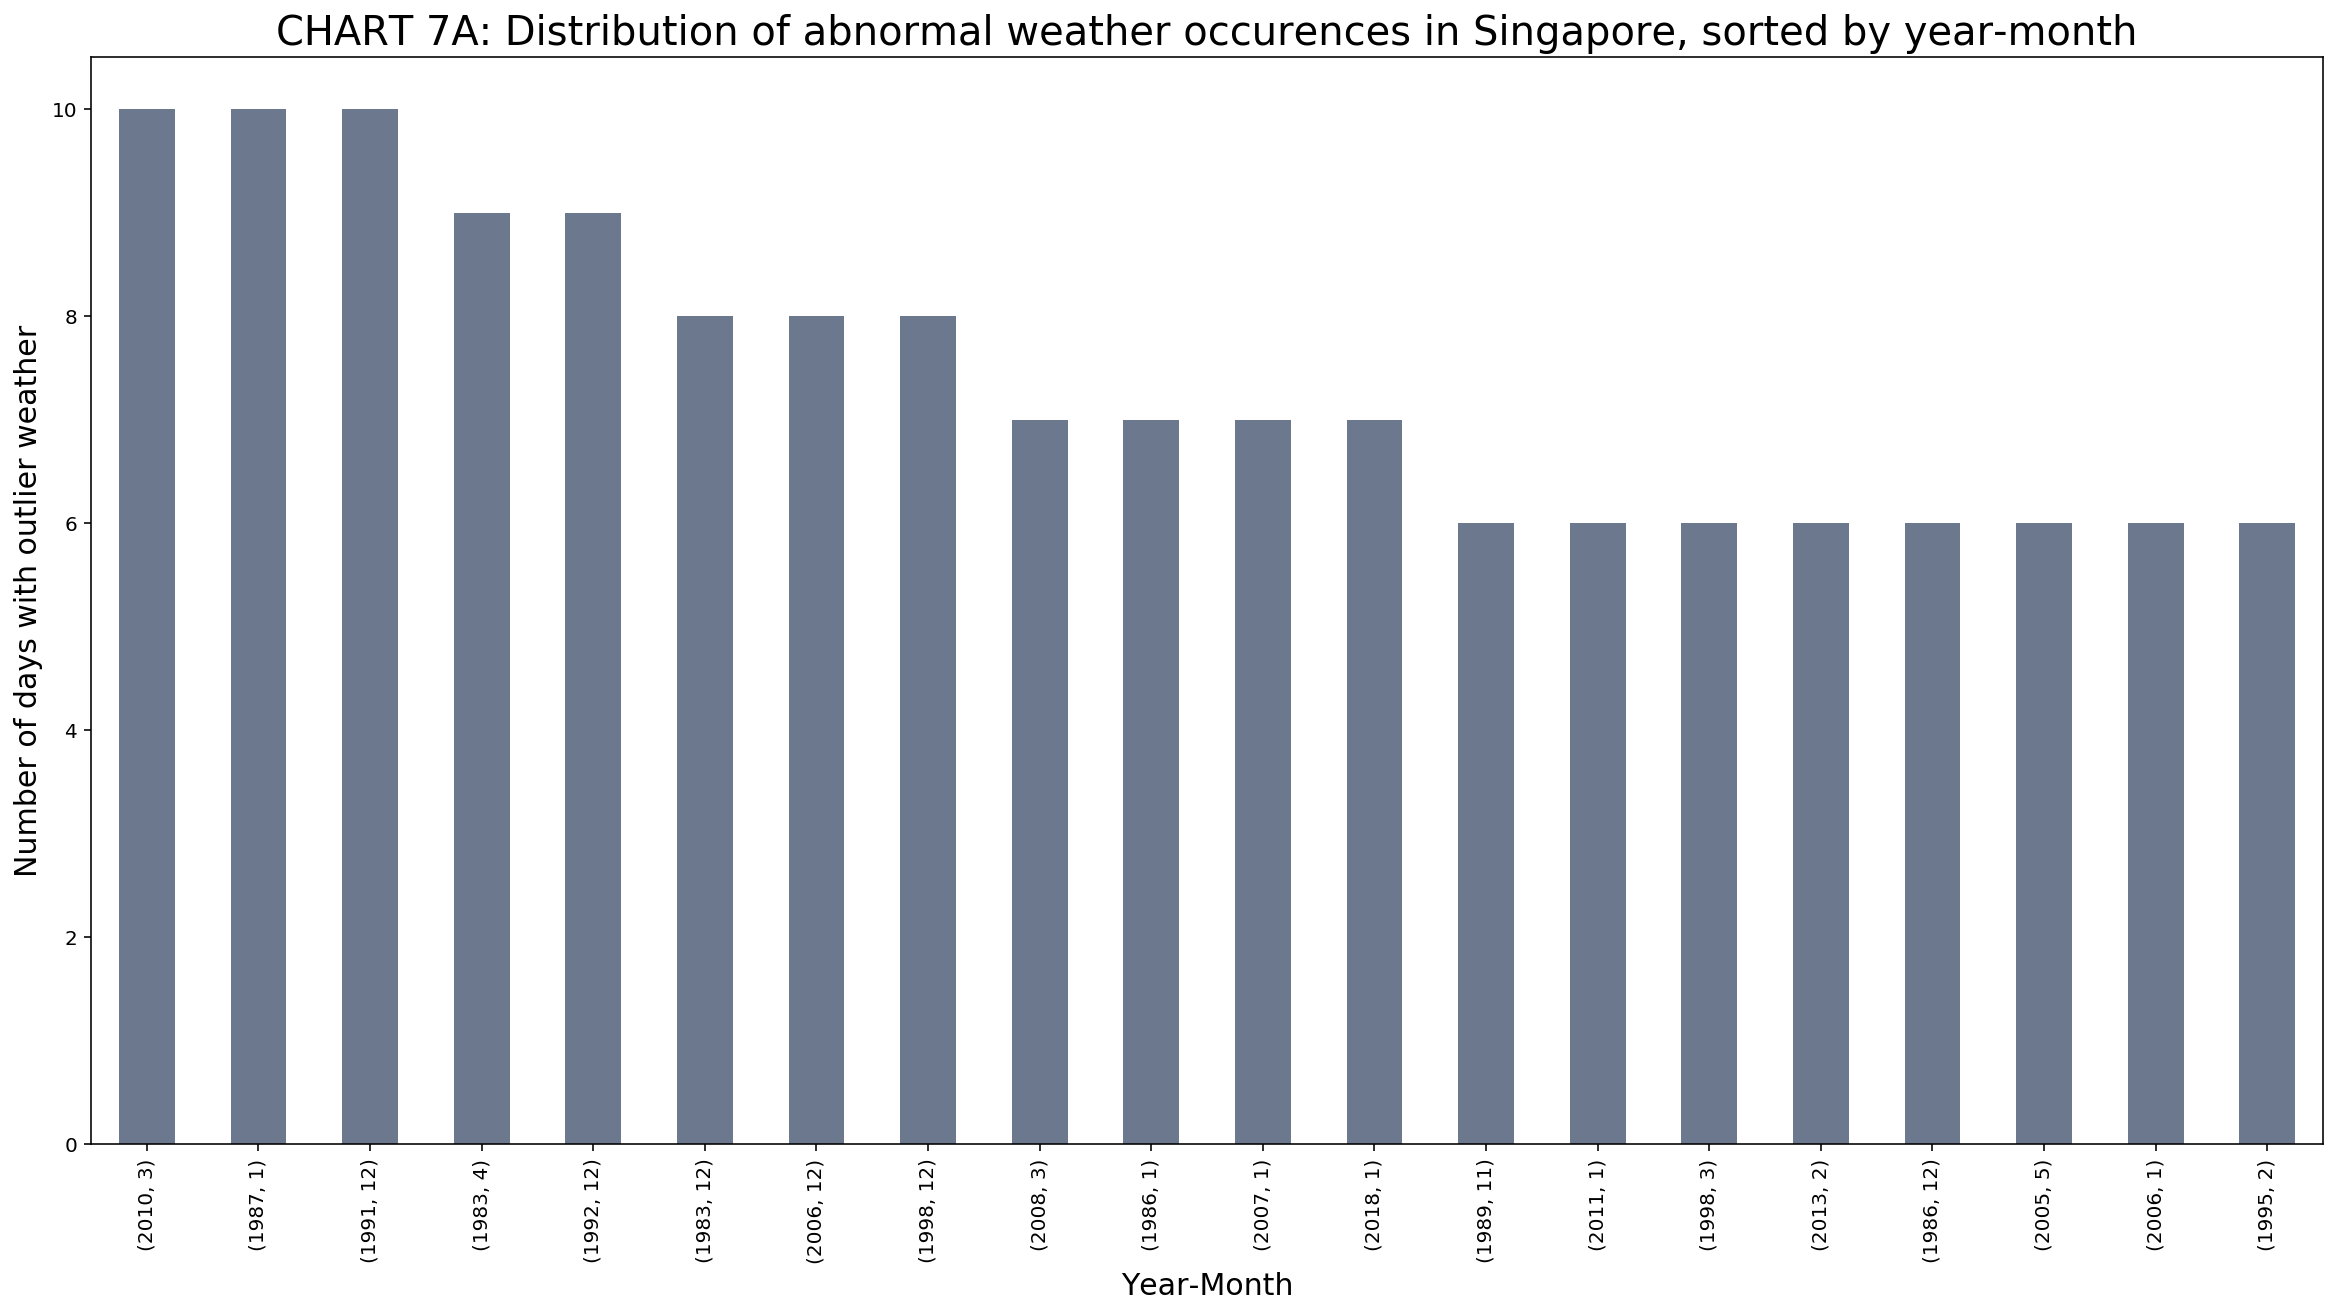

In [32]:
abnormal_weather.groupby(["Year"]).Month.value_counts().sort_values(
    ascending=False
).head(20).plot(kind="bar", 
                figsize=(20, 10),
               color='#6B788D')
plt.title(
    "CHART 7A: Distribution of abnormal weather occurences in Singapore, sorted by year-month",
    fontsize=20,
)
plt.xlabel("Year-Month", fontsize=15)
plt.ylabel("Number of days with outlier weather", fontsize=15)
plt.show()


occurrences## March 2010, January 1987 and December 1991 tie for the most number of abnormal weather occurences in a month - 10 - or about a third. We can dive even deeper to look what the weather was like in those dates picked out by PYOD as outliers

In [33]:
# Trying out a new pandas filtering technique for multiple conditions

crit1 = abnormal_weather['Year'] == 2010
crit2 = abnormal_weather['Month'] == 3
crit3 = abnormal_weather['Year'] == 1991
crit4 = abnormal_weather['Month'] == 12
crit5 = abnormal_weather['Year'] == 1987
crit6 = abnormal_weather['Month'] == 1

march2010 = abnormal_weather[crit1 & crit2]
dec1991 = abnormal_weather[crit3 & crit4]
jan1987 = abnormal_weather[crit5 & crit6]

In [34]:
march2010

Date  Year  Month  Day  Daily Rainfall Total (mm)  \
3378  2010-03-31  2010      3   31                       49.1   
3384  2010-03-25  2010      3   25                       22.9   
3386  2010-03-23  2010      3   23                       57.6   
3389  2010-03-20  2010      3   20                       15.5   
3391  2010-03-18  2010      3   18                       26.4   
3400  2010-03-09  2010      3    9                       28.7   
3402  2010-03-07  2010      3    7                        0.0   
3403  2010-03-06  2010      3    6                        0.0   
3405  2010-03-04  2010      3    4                        0.0   
3406  2010-03-03  2010      3    3                        0.0   

      Mean Temperature (°C)  Maximum Temperature (°C)  \
3378                   27.5                      32.3   
3384                   27.9                      33.3   
3386                   27.6                      30.1   
3389                   25.2                      25.9   
3391                   27.5                      32.4   
3400                   29.8                      35.0   
3402                   29.7                      35.2   
3403                   29.4                      35.5   
3405                   29.4                      35.4   
3406                   29.6                      35.4   

      Minimum Temperature (°C)  Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
3378                      24.1                     6.6                   32.8  
3384                      24.0                     7.4                   30.2  
3386                      23.6                     7.3                   25.6  
3389                      23.6                     7.5                   25.6  
3391                      22.8                     8.8                   40.3  
3400                      26.7                     9.3                   32.0  
3402                      25.9                    11.9                   41.4  
3403                      25.2                    11.5                   40.7  
3405                      25.4                    12.3                   33.8  
3406                      26.0                    11.9                   34.2

## NOTE:

The maximum temperature and daily rainfall columns clearly show why the weather on these dates were considered outliers. The maximum daily temperatures for March 3, 4, 6, 7 and 9 for instances were very high, at 35°C and higher.

The average daily maximum temperature over the last 36 years is 31.5°C, with a standard deviation of 1.6°C. 

March 2010 also saw several days of heavy rainfall, particularly on March 23 (57.6mm) and March 31 (49.1mm). The average daily rainfall over the last 36 years is 5.85mm.

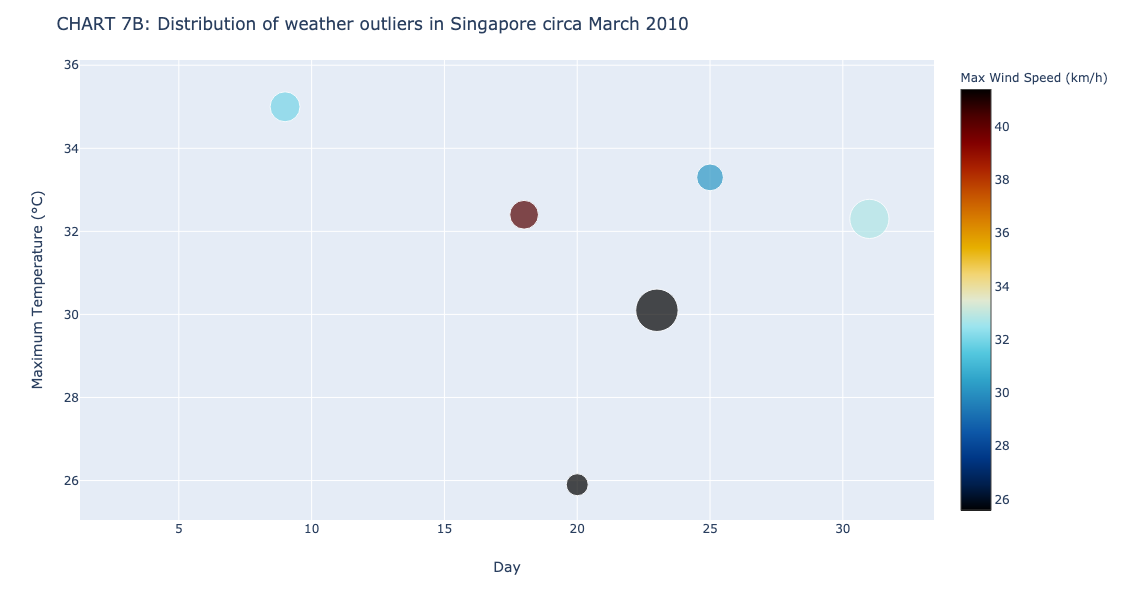

In [35]:
fig = px.scatter(
    abnormal_weather.query("Year==2010").query("Month==3"),
    x="Day",
    y="Maximum Temperature (°C)",
    color="Max Wind Speed (km/h)",
    size="Daily Rainfall Total (mm)",
    size_max = 30,
    hover_name="Date",
    color_continuous_scale=px.colors.cyclical.IceFire,
)
fig.update_layout(
    title=go.layout.Title(
        text="CHART 7B: Distribution of weather outliers in Singapore circa March 2010"
    )
)
fig.show()
# py.plot(fig, filename='../output/march2010.html')
# Download this chart from the "interactive charts" folder in the repo
# Not all 10 days are in this chart; 4 fell outside the range

In [36]:
dec1991

Date  Year  Month  Day  Daily Rainfall Total (mm)  \
10048  1991-12-26  1991     12   26                       61.9   
10051  1991-12-23  1991     12   23                       48.3   
10052  1991-12-22  1991     12   22                       79.4   
10054  1991-12-20  1991     12   20                        5.0   
10059  1991-12-15  1991     12   15                       39.2   
10066  1991-12-08  1991     12    8                       19.2   
10067  1991-12-07  1991     12    7                       68.8   
10068  1991-12-06  1991     12    6                       26.0   
10069  1991-12-05  1991     12    5                       40.2   
10070  1991-12-04  1991     12    4                       13.8   

       Mean Temperature (°C)  Maximum Temperature (°C)  \
10048                   25.9                      30.6   
10051                   24.5                      28.4   
10052                   24.5                      26.8   
10054                   25.3                      26.6   
10059                   25.5                      27.9   
10066                   24.3                      27.3   
10067                   23.1                      23.6   
10068                   23.4                      24.9   
10069                   25.7                      29.8   
10070                   24.1                      25.5   

       Minimum Temperature (°C)  Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
10048                      23.5                     4.5                   39.6  
10051                      23.0                     6.4                   36.4  
10052                      23.4                     5.7                   34.9  
10054                      24.2                    10.0                   47.2  
10059                      23.5                    11.5                   54.4  
10066                      22.6                     9.0                   32.8  
10067                      22.3                     7.5                   42.5  
10068                      22.2                     7.2                   36.4  
10069                      23.5                    10.8                   40.0  
10070                      22.9                     7.0                   37.4

In [37]:
jan1987

Date  Year  Month  Day  Daily Rainfall Total (mm)  \
11840  1987-01-29  1987      1   29                       35.4   
11843  1987-01-26  1987      1   26                       10.0   
11844  1987-01-25  1987      1   25                       60.6   
11846  1987-01-23  1987      1   23                       18.2   
11857  1987-01-12  1987      1   12                       31.1   
11858  1987-01-11  1987      1   11                      127.4   
11859  1987-01-10  1987      1   10                       83.1   
11860  1987-01-09  1987      1    9                       50.0   
11861  1987-01-08  1987      1    8                       67.8   
11862  1987-01-07  1987      1    7                       40.6   

       Mean Temperature (°C)  Maximum Temperature (°C)  \
11840                   23.9                      26.9   
11843                   23.1                      23.9   
11844                   23.9                      25.5   
11846                   25.5                      27.3   
11857                   23.4                      24.2   
11858                   24.7                      27.4   
11859                   23.8                      25.0   
11860                   25.7                      27.5   
11861                   24.3                      25.5   
11862                   24.4                      25.8   

       Minimum Temperature (°C)  Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
11840                      22.1                     3.6                   43.9  
11843                      22.4                     7.4                   42.1  
11844                      22.7                     4.9                   43.2  
11846                      24.4                     1.9                   40.0  
11857                      22.2                     5.6                   46.8  
11858                      23.5                     3.6                   39.2  
11859                      22.8                     3.1                   36.0  
11860                      24.0                     6.5                   44.3  
11861                      23.1                     5.7                   40.7  
11862                      23.3                     7.7                   44.6

## NOTE:

It is clear at a glance why these dates in December 1991 and January 1987 are picked as outliers - the amount of rain on most of these days are very high, including that massive downpour of 127.4mm registered on January 11 1987. That was about 80% of the median monthly rainfall that Singapore got over the last 36 years (160.1mm). I'll plot only for January 1987's outlier weather.

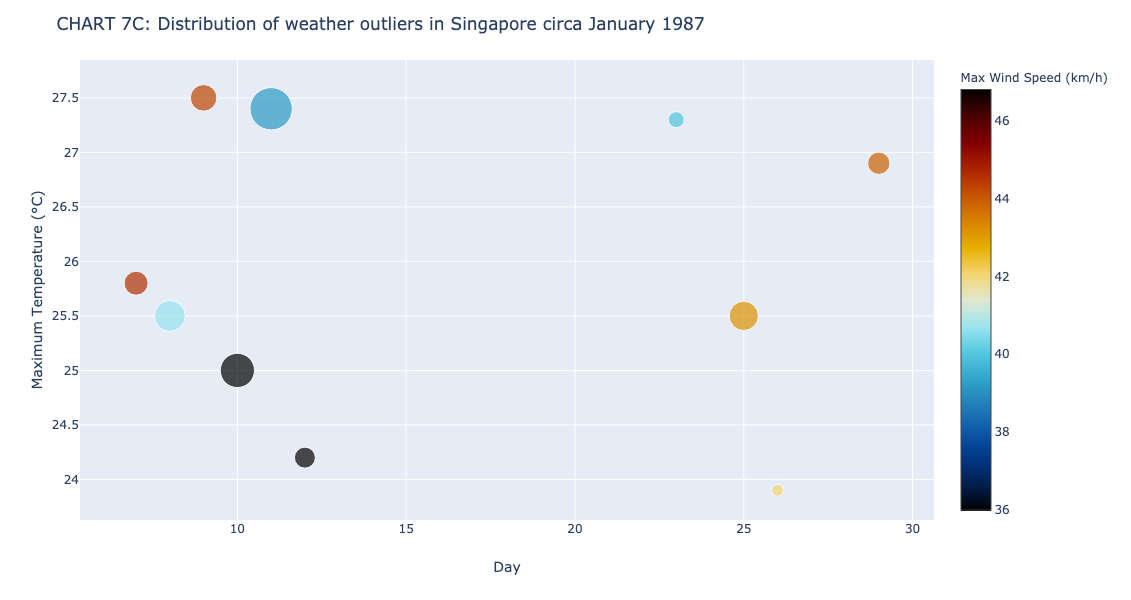

In [38]:
fig = px.scatter(
    abnormal_weather.query("Year==1987").query("Month==1"),
    x="Day",
    y="Maximum Temperature (°C)",
    color="Max Wind Speed (km/h)",
    size="Daily Rainfall Total (mm)",
    size_max = 30,
    hover_name="Date",
    color_continuous_scale=px.colors.cyclical.IceFire,
)
fig.update_layout(
    title=go.layout.Title(
        text="CHART 7C: Distribution of weather outliers in Singapore circa January 1987"
    )
)
fig.show()
# py.plot(fig, filename='../output/jan1987.html')
# Download this chart from the "interactive charts" folder in the repo
# Not all 10 days are in this chart; 4 fell outside the range

## 4.2 BREAKING DOWN THE DISTRIBUTION OF ABNORMAL WEATHER PATTERN - BY YEAR

We can also break down the outliers weather data by year, and see which year had the most number of abnormal weather patterns.

In [39]:
abnormal_weather['Year'].value_counts().sort_values(ascending=False).head(20)

1998    38
1983    34
2013    31
2006    29
1984    29
1986    29
2010    29
2007    29
2008    28
1988    28
2011    25
2003    25
1987    24
2001    24
2016    23
1996    23
1993    23
1992    22
1995    22
2002    22
Name: Year, dtype: int64

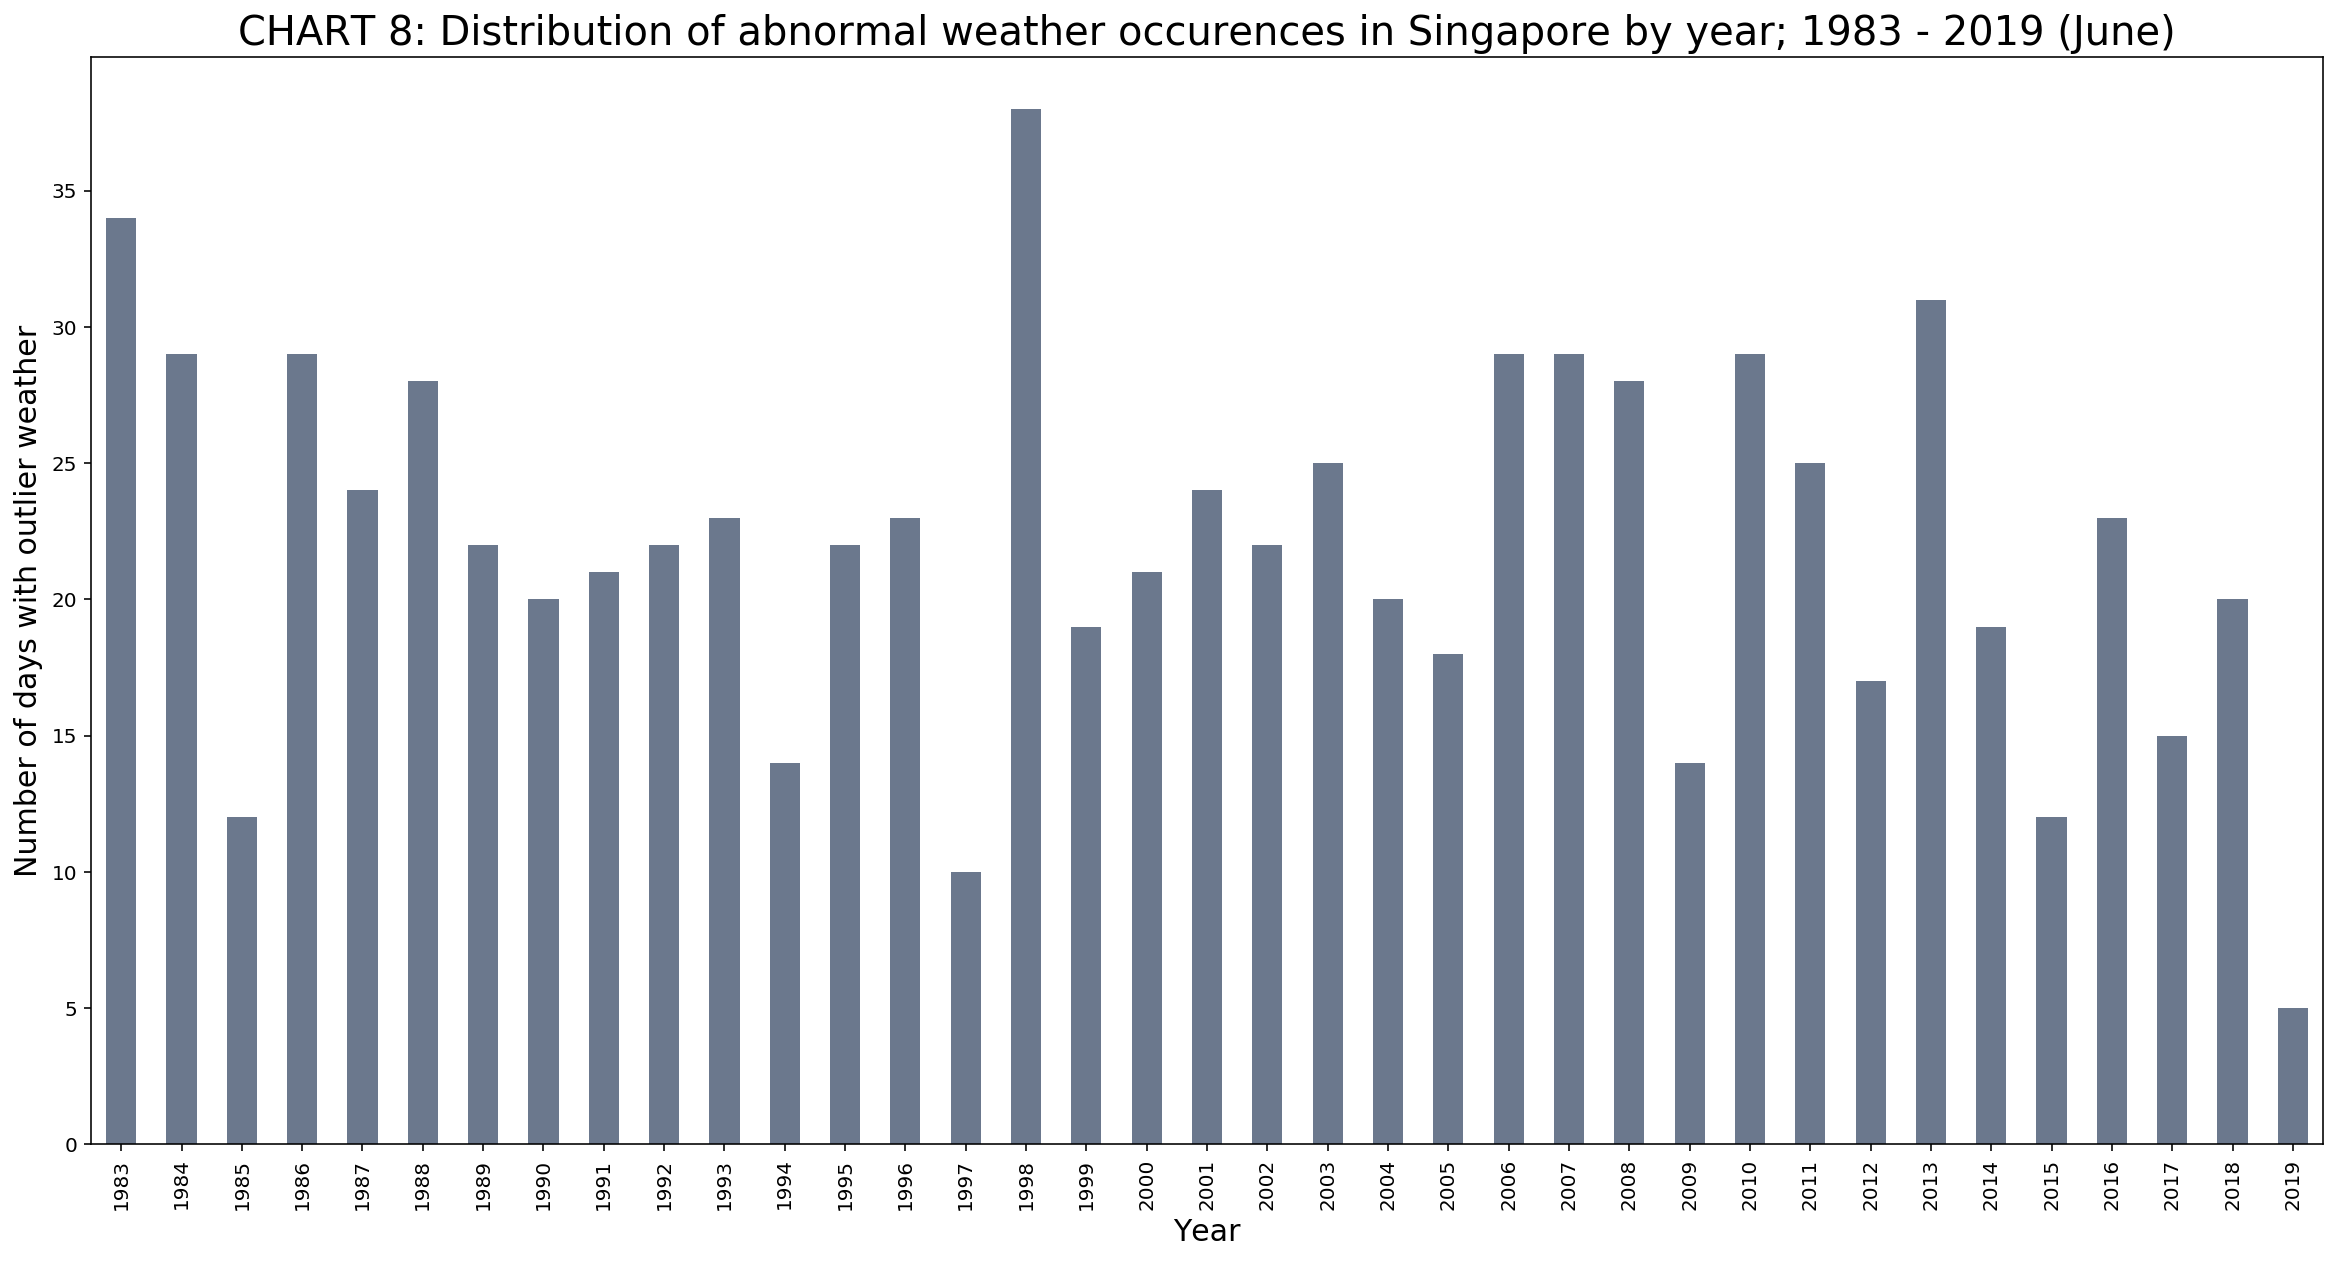

In [40]:
abnormal_weather["Year"].value_counts().sort_index(ascending=True).plot(
    kind="bar", 
    figsize=(20, 10),
    color='#6B788D'
)
plt.title(
    "CHART 8: Distribution of abnormal weather occurences in Singapore by year; 1983 - 2019 (June)",
    fontsize=20,
)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of days with outlier weather", fontsize=15)
plt.show()


## NOTE:

1998 had the most number of abnormal weather occurences, followed by 1983 and 2013. The highest temperature of 36.0°C was recorded on March 26 1998. 

## 4.3 BREAKING DOWN THE DISTRIBUTION OF ABNORMAL WEATHER PATTERN - BY MONTH

In [41]:
abnormal_weather['Month'].value_counts().sort_values(ascending=False)

12    147
1     118
3      83
11     80
4      59
9      57
5      56
7      51
8      42
10     42
6      41
2      40
Name: Month, dtype: int64

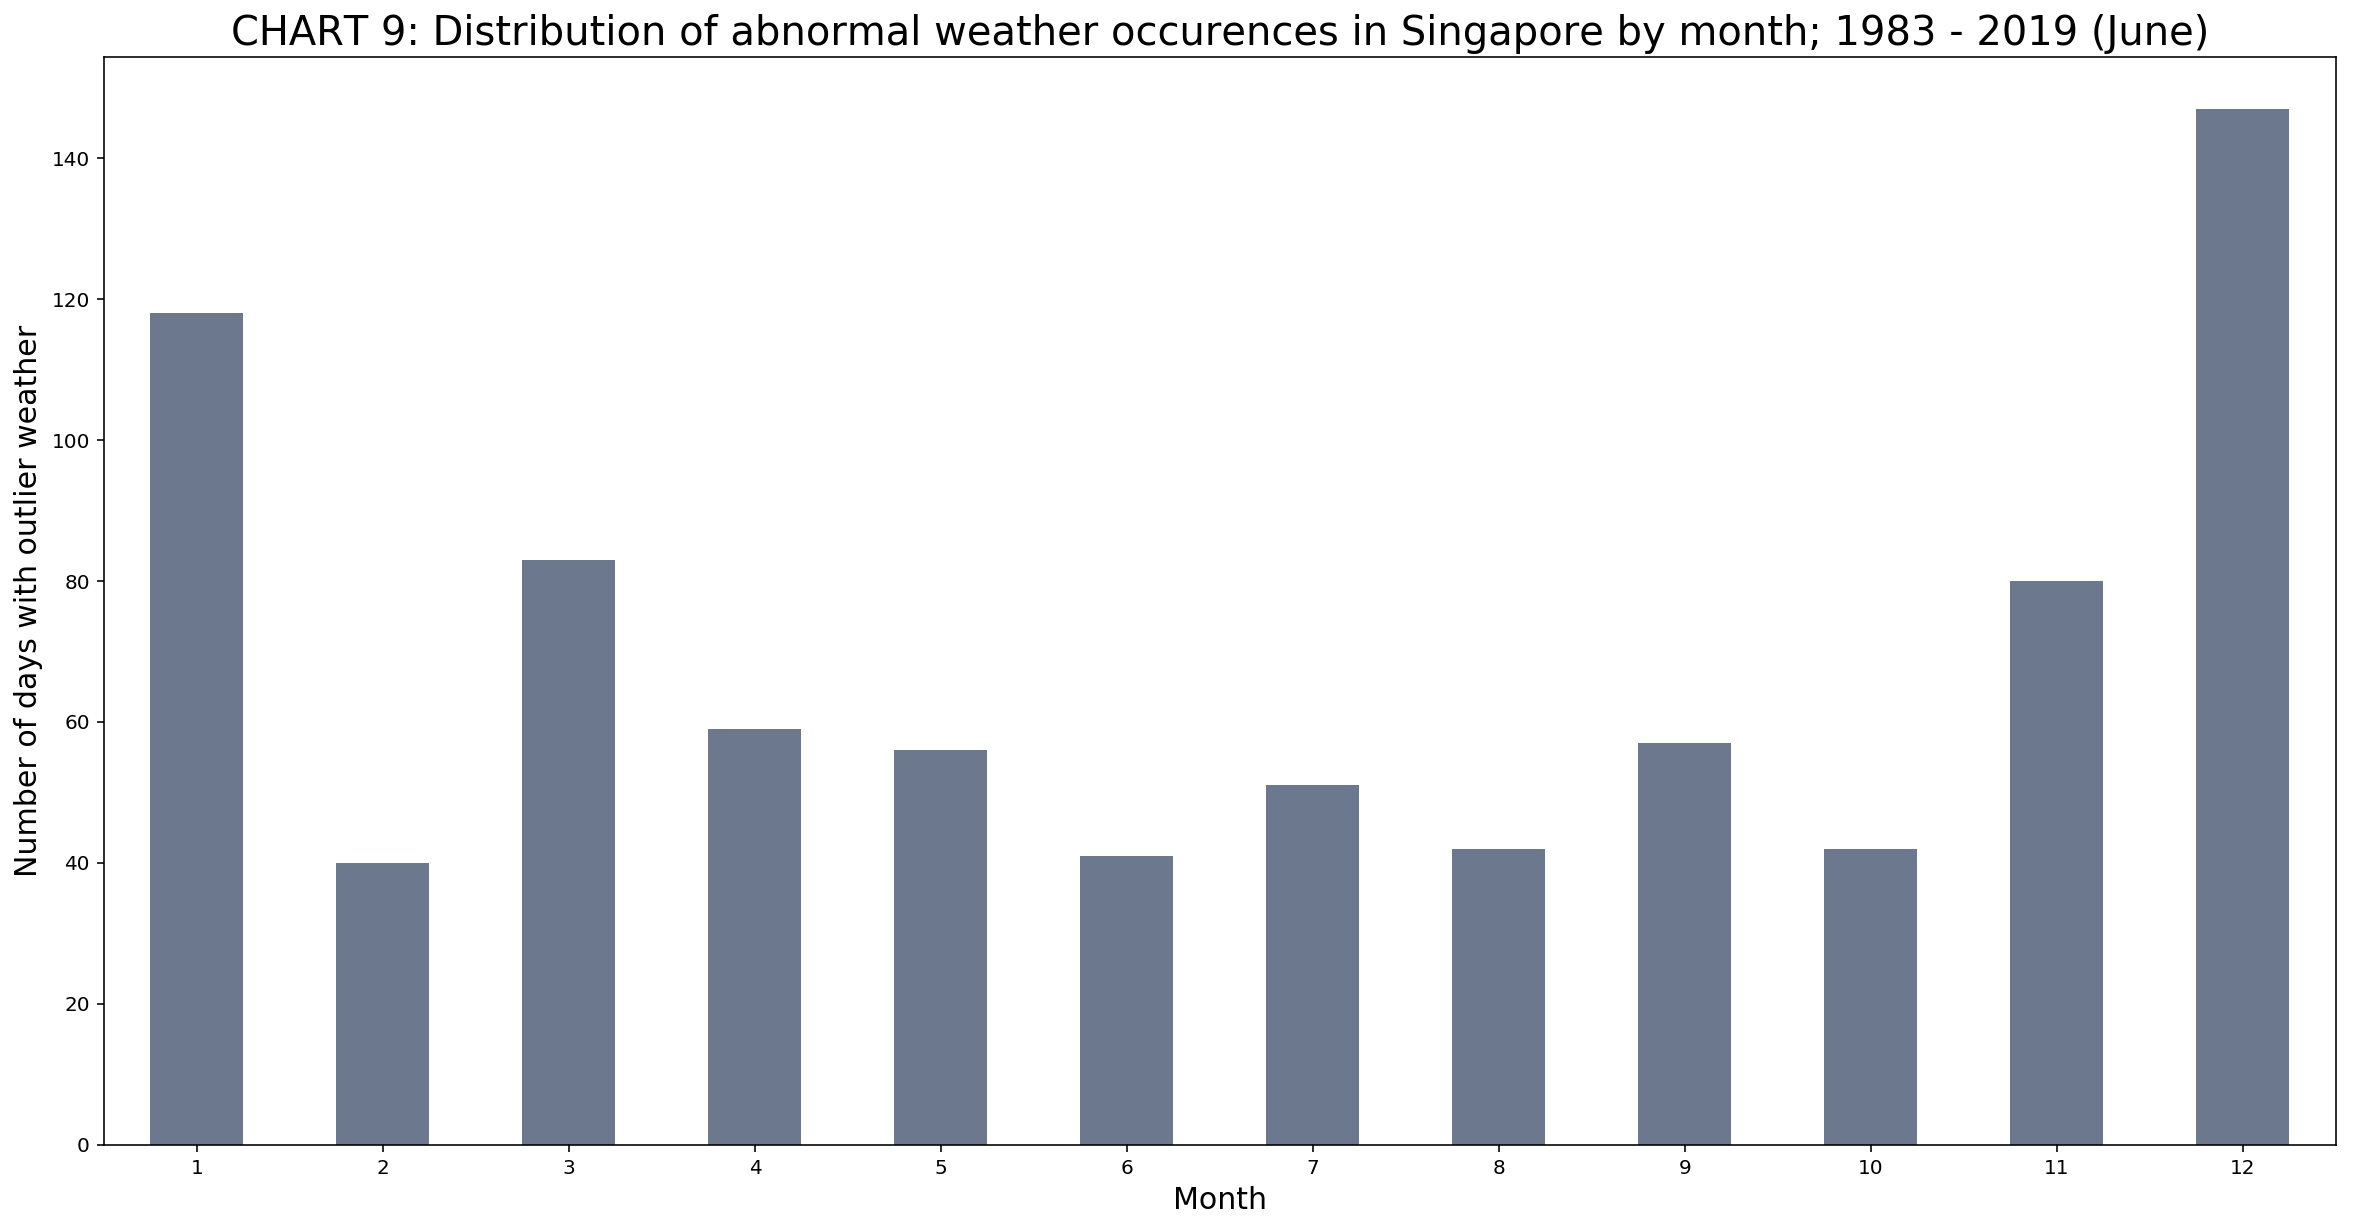

In [42]:
abnormal_weather["Month"].value_counts().sort_index(ascending=True).plot(
    kind="bar", 
    figsize=(20, 10),
    color='#6B788D'
)
plt.title(
    "CHART 9: Distribution of abnormal weather occurences in Singapore by month; 1983 - 2019 (June)",
    fontsize=20,
)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Number of days with outlier weather", fontsize=15)
plt.xticks(rotation=0)
plt.show()


## NOTE:
Over the last 36 years, December and January are the months with the highest number of days with outlier weather - no surprise given the more intense storms during the end and the beginning of the year. 

# 5. MATRIX PANEL COMPARISON
Using a technique I had tried in notebook2.0, I picked 3 years with the highest number of abnormal weather patterns - 2013, 1998, and 1983 as identified by PyOD - and broke them down in a series of matrix panels for easy comparisons.

As we've seen above, the models identified 31 weather outliers in 2013, 38 in 1998 (highest in our dataset) and 34 in 1983.

In the matrix panels below, the larger circles represent days of higher rainfall. Those which are darker and are palced higher up the charts represent days with higher maximum temperature and maximum wind speed. Hover over the individuals points for the exact weather data for that particular outlier.

1998 looks to have the most interesting distribution of outliers, with a noticeable stretch of abnormal weather seen from April to September, aside from the heavy rainfall usually seen in January and December.

|Year| No. of Outliers|
|----|----------------|
|2013|    31|
|1998|    38|
|1983|    34|

The interactive charts can be downloaded from the "interactive charts" folder in this repo.

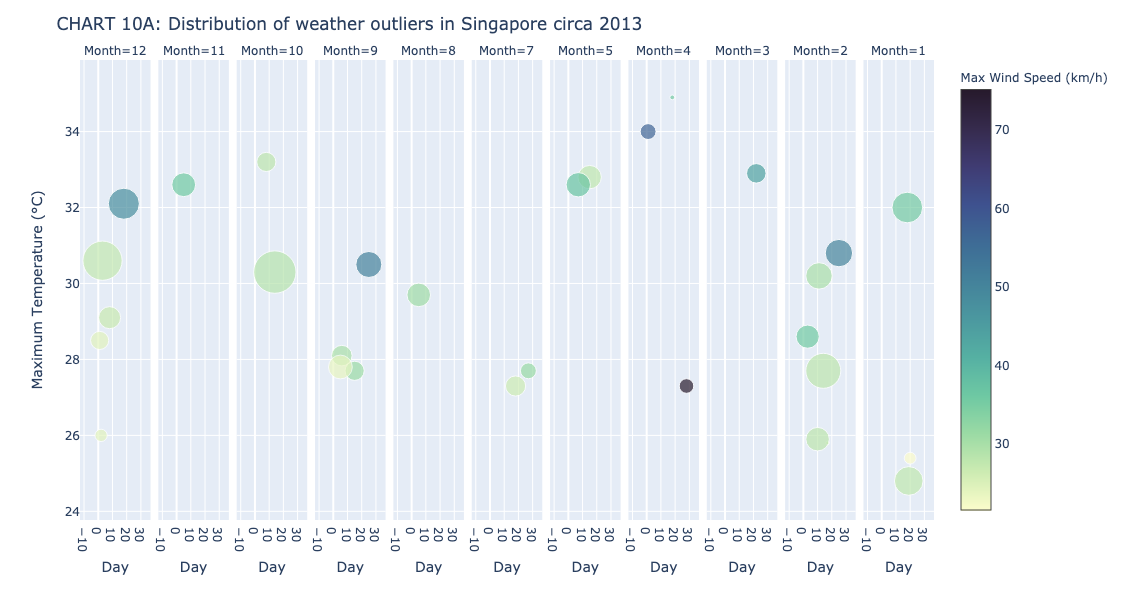

In [43]:
# 2013 has the 3rd highest number of outliers in our dataset - 31
fig = px.scatter(
    abnormal_weather.query("Year==2013"),
    x="Day",
    y="Maximum Temperature (°C)",
    color="Max Wind Speed (km/h)",
    size="Daily Rainfall Total (mm)",
    size_max = 30,
    hover_name="Date",
    facet_col="Month",
    color_continuous_scale=px.colors.sequential.deep,
)
fig.update_layout(
    title=go.layout.Title(
        text="CHART 10A: Distribution of weather outliers in Singapore circa 2013"
    )
)
fig.show()
#py.plot(fig, filename='../output/outliers2013.html')
# Download this chart from the "interactive charts" folder in the repo

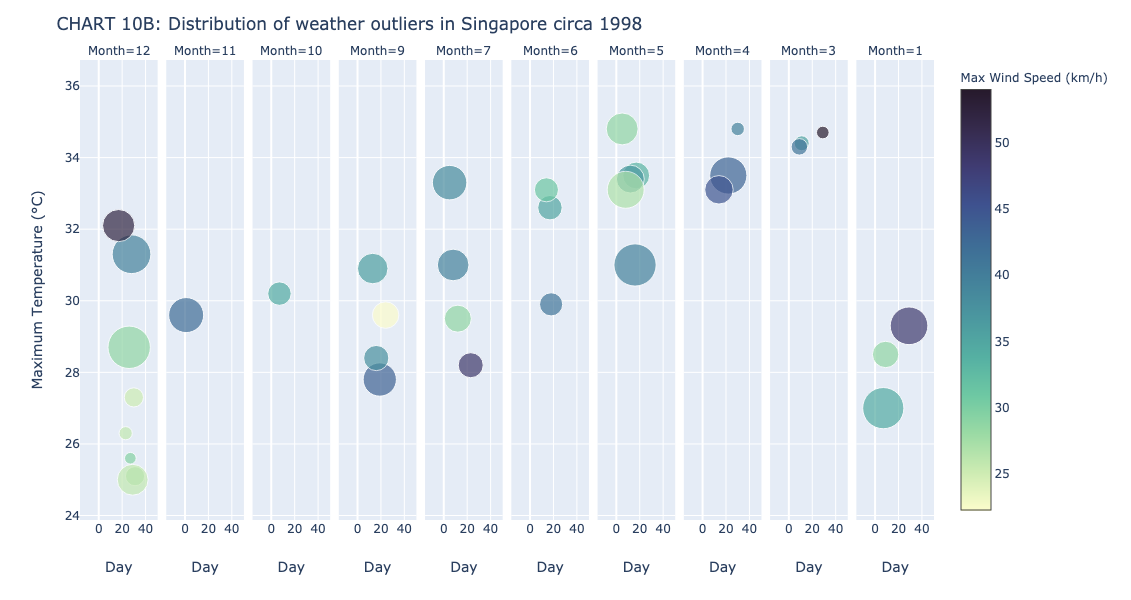

In [44]:
# 1998 had the highest number of outliers in our dataset - 38
fig = px.scatter(
    abnormal_weather.query("Year==1998"),
    x="Day",
    y="Maximum Temperature (°C)",
    color="Max Wind Speed (km/h)",
    size="Daily Rainfall Total (mm)",
    size_max = 30,
    hover_name="Date",
    facet_col="Month",
    color_continuous_scale=px.colors.sequential.deep,
)
fig.update_layout(
    title=go.layout.Title(
        text="CHART 10B: Distribution of weather outliers in Singapore circa 1998"
    )
)
fig.show()
#py.plot(fig, filename='../output/outliers1998.html')
# Download this chart from the "interactive charts" folder in the repo

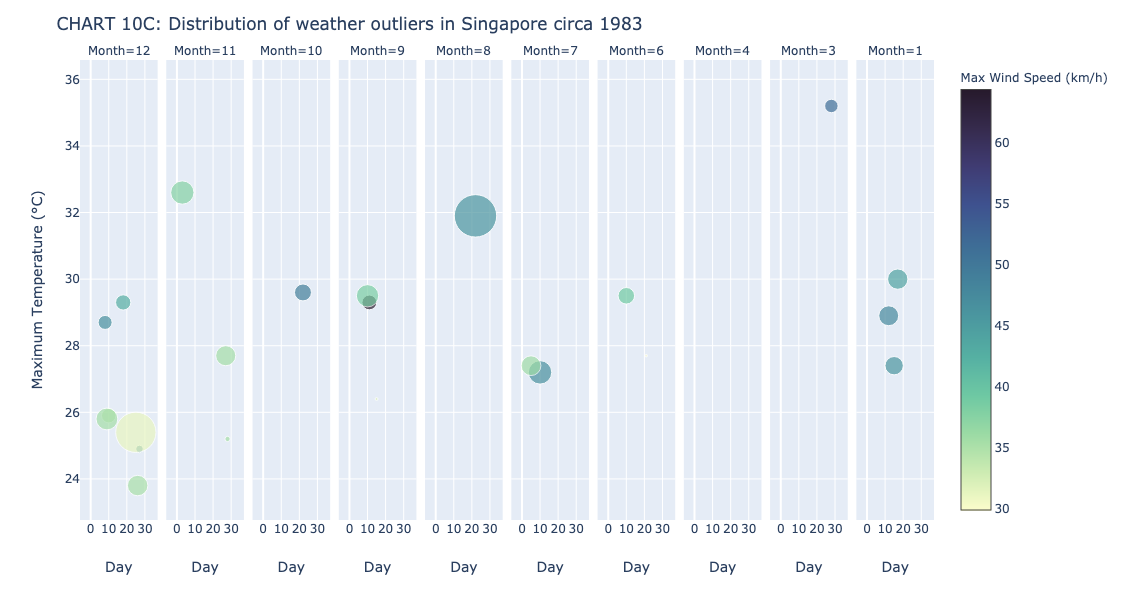

In [45]:
# 1983 had the 2nd highest number of outliers in our dataset - 34
fig = px.scatter(
    abnormal_weather.query("Year==1983"),
    x="Day",
    y="Maximum Temperature (°C)",
    color="Max Wind Speed (km/h)",
    size="Daily Rainfall Total (mm)",
    size_max = 30,
    hover_name="Date",
    facet_col="Month",
    color_continuous_scale=px.colors.sequential.deep,
)
fig.update_layout(
    title=go.layout.Title(
        text="CHART 10C: Distribution of weather outliers in Singapore circa 1983"
    )
)
fig.show()
#py.plot(fig, filename='../output/outliers1983.html')
# Download this chart from the "interactive charts" folder in the repo

# 6. THE OUTLIERS AMONG THE OUTLIERS

Some outliers are obviously more extreme than the others. Let's try to isolate the extreme outliers from the "standard outliers".

In the chart below, the bigger circles signal heavier rainfall. The circles with a darker shade refer to outlier points which are more recent.

Chart 11B is the Plotly interactive version of the same chart. Hover over the individual data points to see how the extreme outliers differ from the rest in the pack.

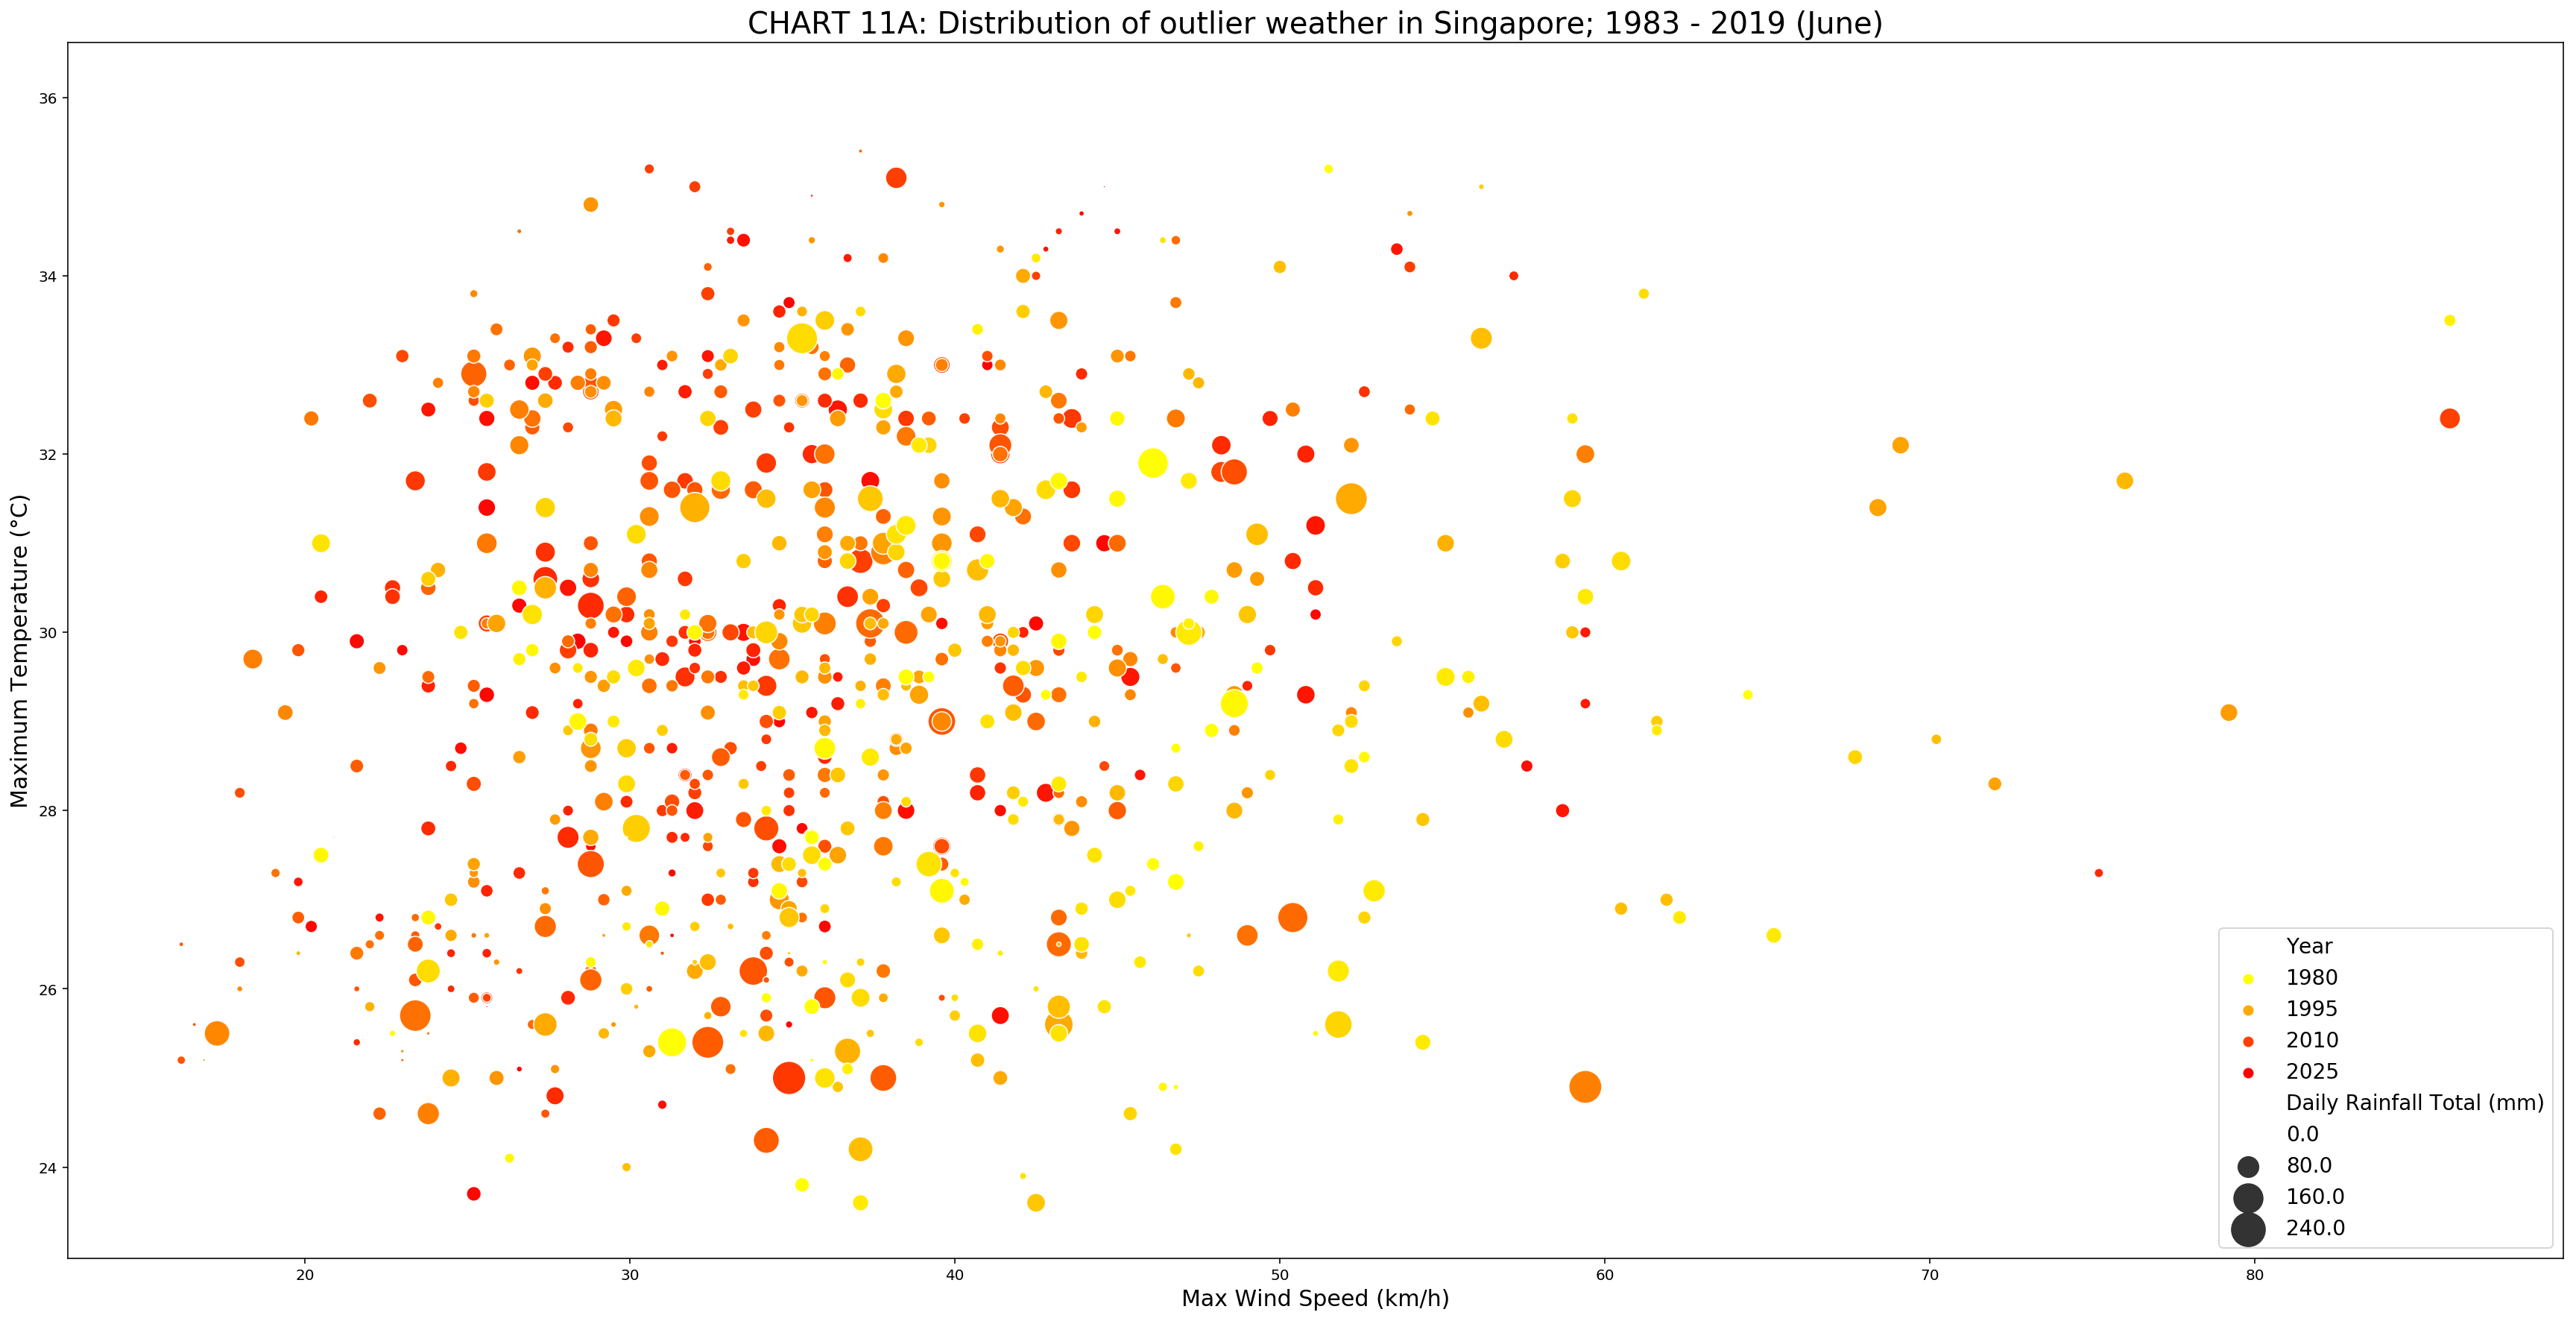

In [46]:
plt.figure(figsize=(30, 15))
sns.scatterplot(
    x="Max Wind Speed (km/h)",
    y="Maximum Temperature (°C)",
    data=abnormal_weather,
    marker="o",
    sizes=(0, 500),
    size="Daily Rainfall Total (mm)",
    hue="Year",
    palette="autumn_r",
)
plt.title("CHART 11A: Distribution of outlier weather in Singapore; 1983 - 2019 (June)", fontsize=20)
plt.xlabel("Max Wind Speed (km/h)", fontsize=15)
plt.ylabel("Maximum Temperature (°C)", fontsize=15)
plt.legend(prop={'size':14})
plt.show()

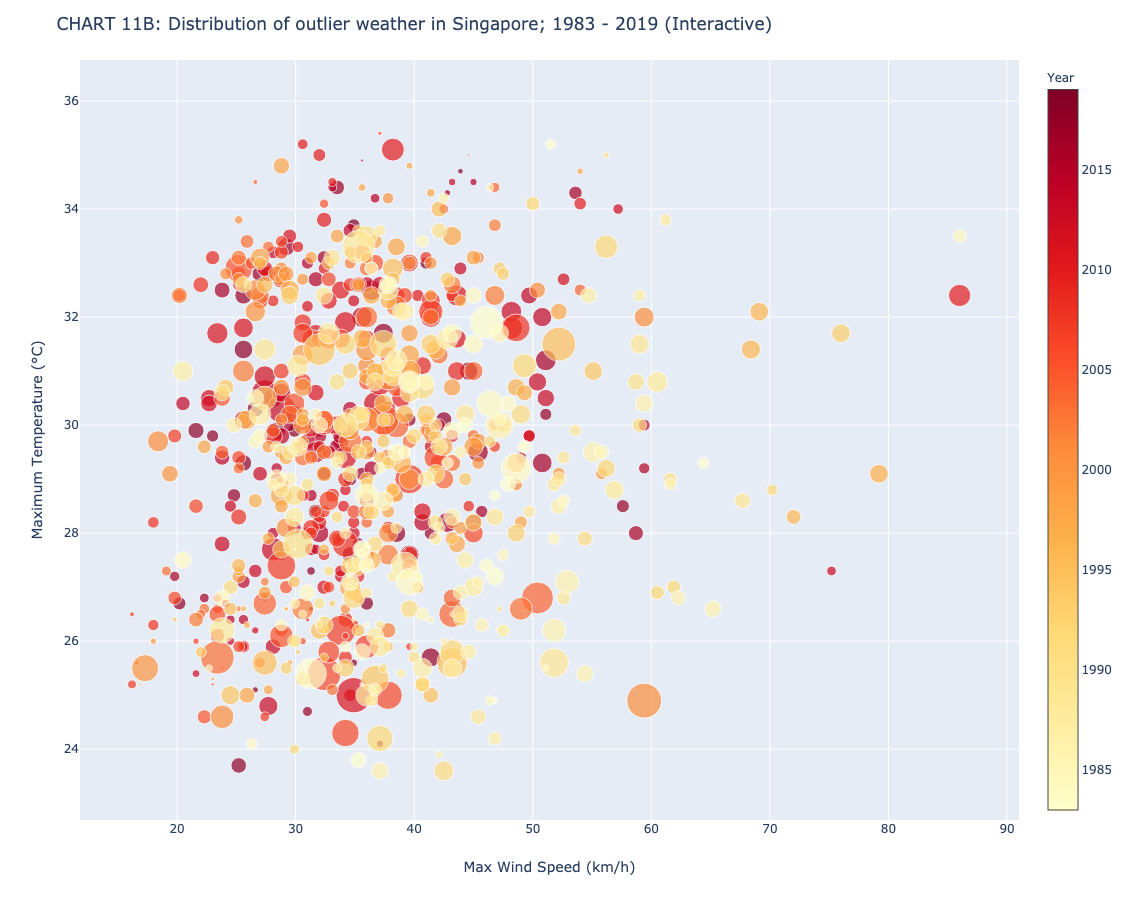

In [47]:
fig = px.scatter(
    abnormal_weather,
    x="Max Wind Speed (km/h)",
    y="Maximum Temperature (°C)",
    color="Year",
    size="Daily Rainfall Total (mm)",
    hover_name="Date",
    size_max=25,
    color_continuous_scale=px.colors.sequential.YlOrRd,
)
fig.update_layout(
    title=go.layout.Title(
        text="CHART 11B: Distribution of outlier weather in Singapore; 1983 - 2019 (Interactive)"
    ),
    autosize=False,
    width=2200,
    height=900
)
fig.show()
#py.plot(fig, filename='../output/outliers_ext.html')
# Download this chart from the "interactive charts" folder in the repo

## NOTE:

We can see a clear cluster in the centre, bounded by maximum temperatures between 26 - 34°C and max wind speed of between 20 - 50kmh. The bigger circles represent days with heavier rainfall.

The more extreme outliers lie to the right, bottom left and top of the chart.

# 7. OUTPUTTING WEATHER FILES FOR FUTURE SEGMENTS

Here, I'm outputting two data sets for future use:

- the abnormal weather data set for comparison with unusual weather patterns in future 

- a "cleaned up" weather set with the 816 outliers removed to be used for time series forecasting and subsequent machine learning tasks

In [48]:
#abnormal_weather.to_csv('../data/abnormal_weather.csv')

In [49]:
weather_new = raw[~raw.Date.isin(outlier_dates)]
#weather_new.to_csv('../data/weather_clean.csv')